<h2>High-Level A/B Test Plan</h2>

<h3>Objectives</h3>

- Revenue: Understand which variant brings more revenue per unit.
- Behavior: Understand how users are engaging differently in each variant.
- Retention: Understand how variants create engagement for users to return to the feature.

<h3>Test Design</h3>

- Each user sees only one variant

<h3>Primary & Secondary Metrics</h3>

- Revenue: 
    - Primary: arpu
    - Secondary: total_purchase_amount

- Behavior: 
    - Primary: purchases_per_day, avg_purchase_amount

- Retention:
    - Primary: Day-N retention rate on cohort_retention_rate
    - Secondary: Day-N retention rate on purchase_retention_rate

<h3>Pre-analysis Checks</h3>

- Normality Checks
- Variance homogeneity

<h3>Statistical Tests Based on Assumptions</h3>

- Normal dist + equal variance -> One-way Anova
- Normal dist + non-equal variance -> Welch Anova
- Non-Normal dist + non-equal variance -> Kruskal

- _Check the flowchart visual to decide which test to go for in which scenario._
<img src="https://statsandr.com/blog/what-statistical-test-should-i-do/images/overview-statistical-tests-statsandr.png" width=2400px height=1400px />


In [1]:
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import levene, f_oneway, kruskal, normaltest, shapiro
import scikit_posthocs as sp
from statsmodels.stats.power import FTestAnovaPower
import statsmodels.api as sm
import pingouin as pg

<h2>Utils</h2>


In [2]:
def perform_data_checks(df):
    
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("""
        No missing values found. """)
    else:
        print("""
        Missing values found:""")
        print(null_counts[null_counts > 0])

    
    if df.duplicated().sum() == 0:
        print("""
        No duplicate rows found. """)
    else:
        print("""
        Duplicate rows found. """)

    
    numeric_cols = df.select_dtypes(include=['number'])
    for col in numeric_cols:
        
        threshold = 3
        z_scores = (df[col] - df[col].mean()) / df[col].std()
        outliers = df[abs(z_scores) > threshold]
        if outliers.empty:
            print(f"""
            No outliers found in column '{col}'. """)
        else:
            print(f"""
            Outliers found in column '{col}': """)
            
def plot_lineplot(df, metric):
    sns.lineplot(data=df, x='date', y=metric, hue='variant', palette='Set1')

def plot_kde(df, metric):
    sns.displot(data = df, 
            x=metric, 
            hue="variant", 
            kind="kde", fill=True, height=3, aspect=1)
    
def calculate_cov(metric):
    df_cov = duckdb.query(f"""
        with new_metrics as (
            select 
                date,
                variant,
                sum(total_purchased_amount) as total_purchased_amount,
                sum(total_purchased_amount) / count(distinct user_id) as arpu
            from df_clean
            group by 1, 2
        )
        , pivoted as (
            select 
                date,
                sum(case when variant = 1 then {metric} else 0 end) as variant_1,
                sum(case when variant = 2 then {metric} else 0 end) as variant_2,
                sum(case when variant = 3 then {metric} else 0 end) as variant_3
            from new_metrics
            group by 1
        )
        , stats AS (
        select 
            date, 
            (variant_1 + variant_2 + variant_3) / 3.0 as avg,
            sqrt((
                power(variant_1 - ((variant_1 + variant_2 + variant_3)/3.0), 2) +
                power(variant_2 - ((variant_1 + variant_2 + variant_3)/3.0), 2) +
                power(variant_3 - ((variant_1 + variant_2 + variant_3)/3.0), 2)
            ) / 2.0) as stddev
        from pivoted
        )
        , cov as (
            select *,
                stddev / avg as cov,
                stddev / avg > 0.5 as is_high_cov          
            from stats
        )
        select * from cov
    """).to_df()

    counts = df_cov["is_high_cov"].value_counts()

    return counts 


def create_groups(df, metric, variant_col="variant"):
    """
        Creates a dictionary of groups for each variant.
    """
    groups = {}
    for variant in sorted(df[variant_col].unique()):
        groups[str(variant)] = df[df[variant_col] == variant][metric]
    return groups


def variance_homogeneity_test(df, metric):
    """ 
        This function helps us understand if the selected metric is homogeneous amongst different variants by using Levene's test.
    """
    groups = create_groups(df, metric) 
    
    levene_result = levene(groups["1"], groups["2"], groups["3"])

    print(f"Levene's Test: Score = {levene_result.statistic:.4f}, p-value = {levene_result.pvalue:.5f}")

    if levene_result.pvalue < 0.05:
        print(f"The variances are NOT equal for the {metric}.")
    else:
        print(f"The variances are equal for the {metric}.")

    return levene_result.statistic, levene_result.pvalue 


def apply_log_transform(df, metric):
    """
    Applies log(1 + x) transformation to the selected metric.
    This is useful when the metric is right-skewed or has outliers.
    """
    df = df.copy()
    df[f"log_{metric}"] = np.log1p(df[metric])
    return df


def parametric_one_way_anova_test(df, metric, log_transform = False):
    """
    This function helps us understand if the selected metric is differs amongst different variants by using one-way ANOVA test with or without log-transform based on the normality tests.
    The null hypothesis is that all group means are equal.
    """
    df = df.copy()

    if log_transform:
        df = apply_log_transform(df, metric)
        metric_col = f"log_{metric}"
    else:
        metric_col = metric

    groups = create_groups(df, metric_col)

    f_statistic, p_value = f_oneway(groups["1"], groups["2"], groups["3"])
    
    print(f"One-Way ANOVA {'(log-transformed)' if log_transform else ''} — F = {f_statistic:.4f}, p = {p_value:.5f}")

    if p_value < 0.05:
        print(f"Reject H0: At least one group mean is significantly different for '{metric}'.")
    else:
        print(f"Fail to reject H0: No significant difference between group means for '{metric}'.")

    return f_statistic, p_value


def parametric_welch_anova_test(df, metric, log_transform=False):
    """
    Thia function helps us understand if the selected metric is differs amongst different variants by using Welch's ANOVA test. Welch anova is doesn't require variance homogenenity. It still requires normality though.
    """
    df = df.copy()

    if log_transform:
        df = apply_log_transform(df, metric)
        metric_col = f"log_{metric}"
    else:
        metric_col = metric

    result = pg.welch_anova(dv=metric_col, between='variant', data=df)
    f_stat = result['F'].values[0]
    p_value = result['p-unc'].values[0]

    print(f"Welch ANOVA {'(log-transformed)' if log_transform else ''} — F = {f_stat:.4f}, p = {p_value:.5f}")

    if p_value < 0.05:
        print(f"Reject the null hypothesis: at least one group mean is significantly different for the {metric} metric.")
    else:
        print(f"Fail to reject the null hypothesis: no significant difference between group means for the {metric} metric.")

    return result 

def non_parametric_anova_kruskal_test(df, metric):
    """
        This function helps us understand if the selected metric is differs amongst different variants by using Kruskal-Wallis test.
        We don't make any assumptions about the distribution of the data here.
    """
    groups = create_groups(df, metric) 
    
    h_statistic, p_value = kruskal(groups["1"], groups["2"], groups["3"])
    print(f"H-score: {h_statistic:.4f}, p-value: {p_value:.5f}")
    if p_value < 0.05:
        print(f"Reject the null hypothesis: at least one group mean is significantly different for the {metric} metric.")
    else:
        print(f"Fail to reject the null hypothesis: no statistically significant difference found between group means for the {metric} metric.")

    return h_statistic, p_value 


def posthoc_nonparametric(df, metric, variant_col="variant"):
    """
        This function helps us understand which groups are significantly different from each other by using Dunn's test.
    """
    df[variant_col] = df[variant_col].astype(str)

    dunn_result = sp.posthoc_dunn(
        df, 
        val_col=metric, 
        group_col=variant_col, 
        p_adjust="bonferroni"
    )
     
    return dunn_result

def posthoc_parametric(df, metric, variant_col="variant"):
    """
        This function helps us understand which groups are significantly different from each other by using Tukey's test.
    """
    df[variant_col] = df[variant_col].astype(str)

    tukey_result = sp.posthoc_tukey(
        df, 
        val_col=metric, 
        group_col=variant_col
    )
    
    return tukey_result

<h2>Initial Checks</h2>

In [3]:
df = pd.read_csv("/Users/korcankomili/Downloads/hornet.csv")

df["DATE"] = pd.to_datetime(df["DATE"], format="%Y/%m/%d")
df["Total_purchased_amount"] = df["Total_purchased_amount"].str.replace(",", ".").astype(float)
df.columns = ['date', 'user_id', 'variant', 'purchases', 'total_purchased_amount']
df["avg_purchase_amount"] = df["total_purchased_amount"] / df["purchases"]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79999 entries, 0 to 79998
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    79999 non-null  datetime64[ns]
 1   user_id                 79999 non-null  int64         
 2   variant                 79999 non-null  int64         
 3   purchases               79999 non-null  int64         
 4   total_purchased_amount  79999 non-null  float64       
 5   avg_purchase_amount     79999 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 3.7 MB


In [5]:
perform_data_checks(df)


        No missing values found. 

        No duplicate rows found. 

            No outliers found in column 'user_id'. 

            No outliers found in column 'variant'. 

            Outliers found in column 'purchases': 

            Outliers found in column 'total_purchased_amount': 

            Outliers found in column 'avg_purchase_amount': 


In [6]:
sample_contamination_result = duckdb.query("""
	select 
        count(*) > 1 as sample_contamination
    from (
        select 
            user_id
        from df
        group by user_id 
        having count(DISTINCT variant) > 1 
    ) as t    
""").to_df()

if sample_contamination_result["sample_contamination"][0]:
    print("there is sample contamination, we should remove those users from the dataset to avoid bias and keep the dataset clean and isolated.")
else:
    print("there is no sample contamination, we can proceed with the analysis.")

there is sample contamination, we should remove those users from the dataset to avoid bias and keep the dataset clean and isolated.


In [7]:
df_clean = duckdb.query("""
    with sample_contamination as (
        select 
            user_id
        from df
        group by user_id 
        having count(distinct variant) > 1 
    )
    , clean as (
        select *
        from df 
        where user_id not in (
            select
                user_id 
            from sample_contamination
        )
    )
    select * from clean
""").to_df()

print(f"""
    {(len(df) - len(df_clean)) / len(df) * 100:.2f}% of the dataset was contaminated.
    {len(df) - len(df_clean)} rows are cleaned.
""")


    7.04% of the dataset was contaminated.
    5631 rows are cleaned.



In [8]:
variant_samples = df_clean.groupby("variant")["user_id"].nunique().reset_index()

print(variant_samples)

   variant  user_id
0        1    16595
1        2    15931
2        3    15987


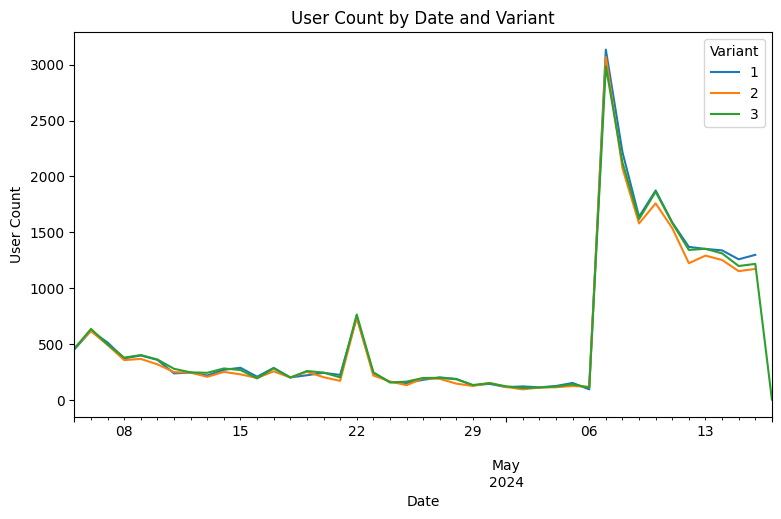

In [9]:
df_clean.groupby(["date", "variant"])["user_id"].nunique().reset_index().pivot(
    index="date", columns="variant", values="user_id"
).plot(figsize=(9, 5), title="User Count by Date and Variant")
plt.xlabel("Date")
plt.ylabel("User Count")
plt.legend(title="Variant")
plt.show()

It looks like the variant cohorts are stable over time. There is no missing dates or peaks for individual variants. The tests looks balanced, each variant was active for the full duration and had comparable cohort presence.

In [10]:
min_date = df_clean['date'].min()
max_date = df_clean['date'].max()

print(f"Min date: {min_date} and max date: {max_date}, test duration: {(max_date - min_date)}")

if (max_date - min_date).days < 14:
    print("The test duration is less than 14 days, we should extend the test duration to get more reliable results.")
else:
    print("The test duration is more than 14 days, we can proceed with the analysis.")

Min date: 2024-04-05 00:00:00 and max date: 2024-05-17 00:00:00, test duration: 42 days 00:00:00
The test duration is more than 14 days, we can proceed with the analysis.


In [11]:
# Understanding MDE : Minimum Detectable Effect Size
# Cohen's f is the effect size for ANOVA 

anova_analysis = FTestAnovaPower()

# Sample size per group
n_per_group = df_clean.groupby("variant")["user_id"].nunique().min()

# Desired test settings
alpha = 0.05
power = 0.8
groups = 3

# Calculate the MDE for 3 groups
mde_anova = anova_analysis.solve_power(
    effect_size=None, nobs=n_per_group * groups, 
    alpha=alpha, 
    power=power, 
    k_groups=groups
    )

print(f"Minimum Detectable Effect Size (Cohen's f): {mde_anova:.4f}")
print(f"To detect an ~{round(mde_anova*100*2)}% difference, this test is well-powered.")


Minimum Detectable Effect Size (Cohen's f): 0.0142
To detect an ~3% difference, this test is well-powered.


- Our sample size is large enough to detect even small differences. 
- So if we don’t find a significant result, we can be confident that there’s no real effect worth chasing. 
- If we do find significance, we need to analyze further to make sure that there is business impact.

## Question-1

**Is there a difference between the different versions regarding daily revenue?**

### Plan

- I will use daily-level data (not user-level) to compare how variants perform each day in terms of:
  - Primary metric: ARPU
  - Secondary metric: total purchased amount

- To monitor daily stability, I calculate the coefficient of variation (CoV) for each variant. It helps confirm that there’s no wild inconsistency before running statistical tests.

- Then I run both ANOVA (parametric) and Kruskal-Wallis (non-parametric):
  - ANOVA checks for mean differences but assumes normality and equal variances
  - Kruskal-Wallis compares rank distributions and doesn’t rely on distribution assumptions

- I check the distribution and variance homogeneity before deciding which test result to trust:
  - If assumptions hold, then rely on ANOVA
  - If not, then use Kruskal-Wallis
  - If both tests agree, the result is more solid.

- If this had been just A/B (2 groups), I would use a t-test or Mann-Whitney instead — same logic, just for two groups.

In [12]:
df_daily = df_clean.groupby(["date", "variant"])[["purchases", "total_purchased_amount", "user_id"]].agg(
    total_purchased_amount=("total_purchased_amount", "sum"),
    purchases=("purchases", "sum"),
    user_count = ("user_id", "nunique"),
).reset_index()

df_daily["avg_purchase_amount"] = df_daily["total_purchased_amount"] / df_daily["purchases"]
df_daily["arpu"] = df_daily["total_purchased_amount"] / df_daily["user_count"]

df_daily.head()

,date,variant,total_purchased_amount,purchases,user_count,avg_purchase_amount,arpu
0,2024-04-05,1,51538.3,269286,452,0.191389,114.022788
1,2024-04-05,2,49238.4,280596,465,0.175478,105.889032
2,2024-04-05,3,47466.1,273600,458,0.173487,103.637773
3,2024-04-06,1,79385.5,374343,619,0.212066,128.247981
4,2024-04-06,2,59199.6,312933,615,0.189177,96.259512


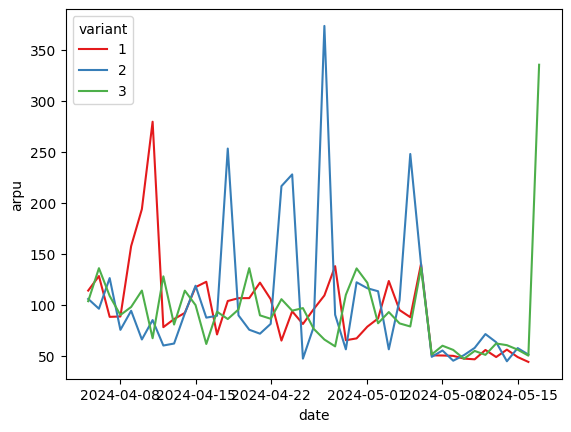

In [13]:
plot_lineplot(df_daily, "arpu")

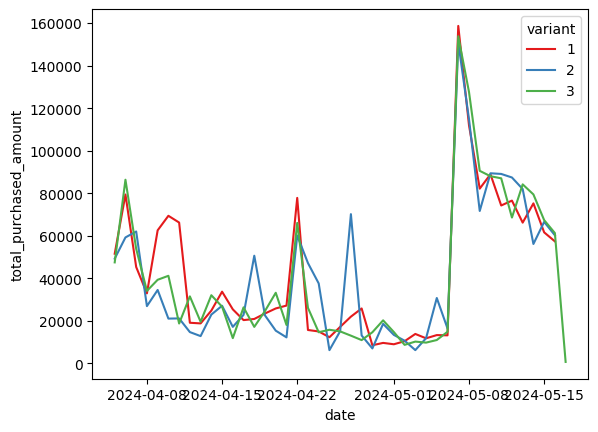

In [14]:
plot_lineplot(df_daily, "total_purchased_amount")

In [15]:
print(calculate_cov(metric="arpu"))

is_high_cov
False    35
True      8
Name: count, dtype: int64


In [16]:
print(calculate_cov(metric="total_purchased_amount"))

is_high_cov
False    35
True      8
Name: count, dtype: int64


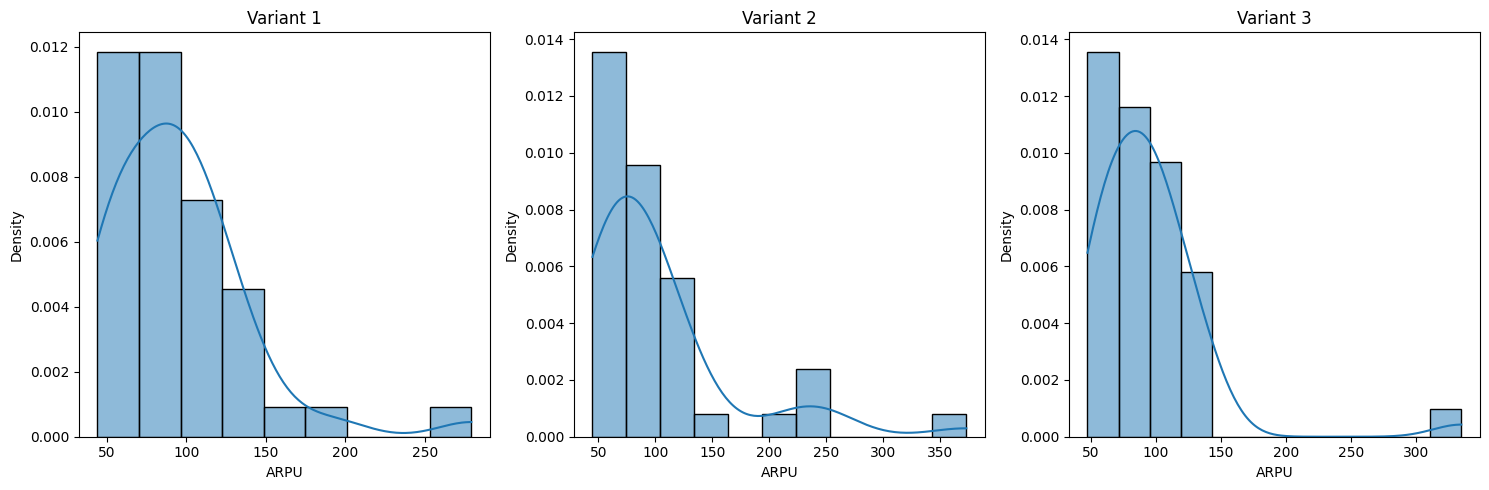

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.histplot(data=df_daily[df_daily["variant"] == i+1], x="arpu", kde=True, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Variant {i+1}") 
    ax.set_xlabel("ARPU")  
    ax.set_ylabel("Density") 

plt.tight_layout()
plt.show()

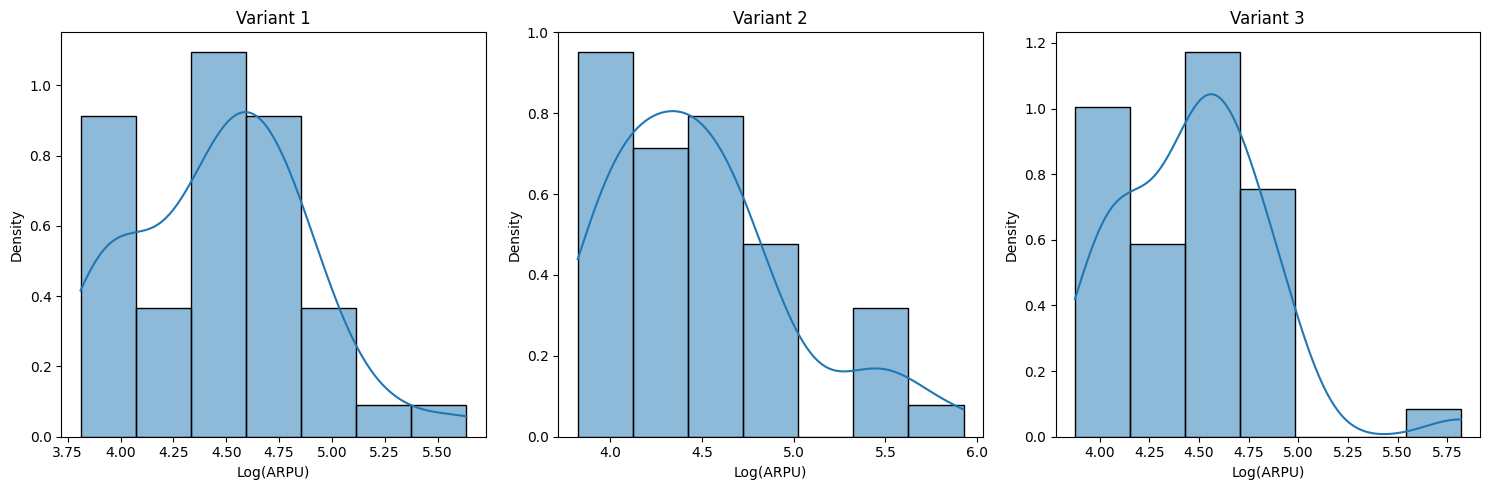

In [18]:
df_daily_log = apply_log_transform(df_daily, "arpu")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.histplot(data=df_daily_log[df_daily_log["variant"] == i+1], x="log_arpu", kde=True, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Variant {i+1}") 
    ax.set_xlabel("Log(ARPU)")  
    ax.set_ylabel("Density") 

plt.tight_layout() 
plt.show()

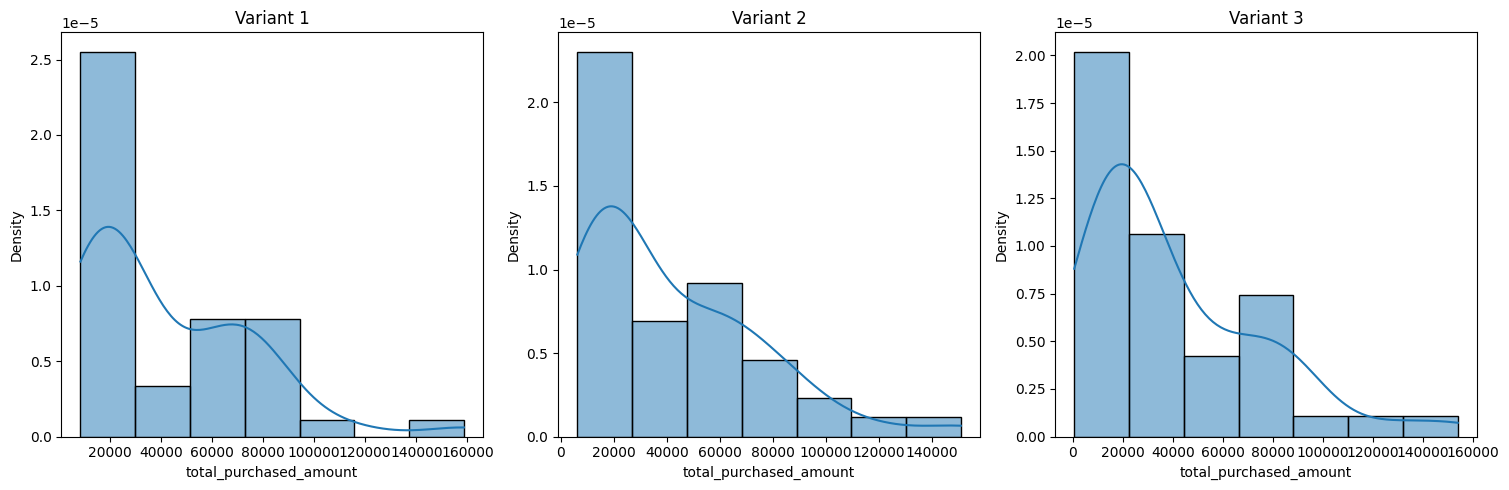

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.histplot(data=df_daily[df_daily["variant"] == i+1], x="total_purchased_amount", kde=True, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Variant {i+1}") 
    ax.set_xlabel("total_purchased_amount")  
    ax.set_ylabel("Density") 

plt.tight_layout()
plt.show()

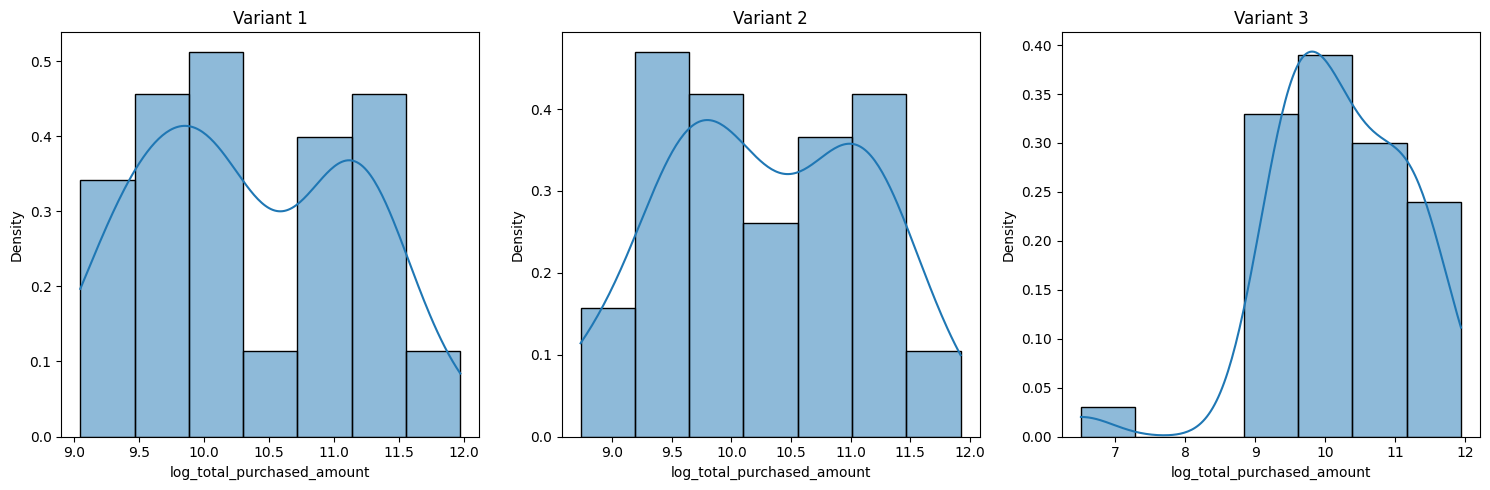

In [20]:
df_daily_log = apply_log_transform(df_daily, "total_purchased_amount")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.histplot(data=df_daily_log[df_daily_log["variant"] == i+1], x="log_total_purchased_amount", kde=True, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Variant {i+1}") 
    ax.set_xlabel("log_total_purchased_amount")  
    ax.set_ylabel("Density") 

plt.tight_layout()
plt.show()

In [21]:
print("""

variance homogeneity before log-transform for arpu
""")
variance_homogeneity_test(df_daily, "arpu")


print("""

variance homogeneity before log-transform for total_purchased_amount
""")
variance_homogeneity_test(df_daily, "total_purchased_amount")


##

print("""

variance homogeneity after log-transform for arpu
""")
variance_homogeneity_test(apply_log_transform(df_daily, "arpu"), "log_arpu")


print("""

variance homogeneity after log-transform for total_purchased_amount
""")
variance_homogeneity_test(apply_log_transform(df_daily, "total_purchased_amount"), "log_total_purchased_amount")



variance homogeneity before log-transform for arpu

Levene's Test: Score = 1.1194, p-value = 0.32976
The variances are equal for the arpu.


variance homogeneity before log-transform for total_purchased_amount

Levene's Test: Score = 0.0010, p-value = 0.99904
The variances are equal for the total_purchased_amount.


variance homogeneity after log-transform for arpu

Levene's Test: Score = 1.2690, p-value = 0.28473
The variances are equal for the log_arpu.


variance homogeneity after log-transform for total_purchased_amount

Levene's Test: Score = 0.1817, p-value = 0.83406
The variances are equal for the log_total_purchased_amount.


(np.float64(0.18171685620576086), np.float64(0.8340590490742366))

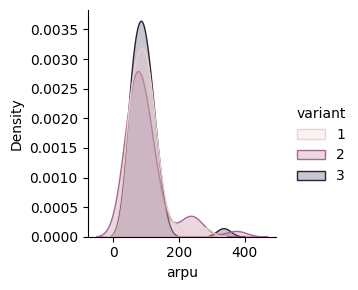

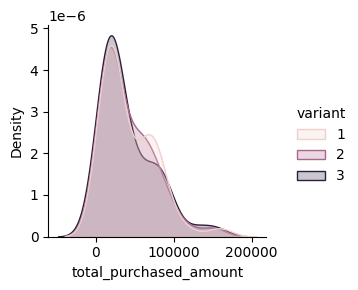

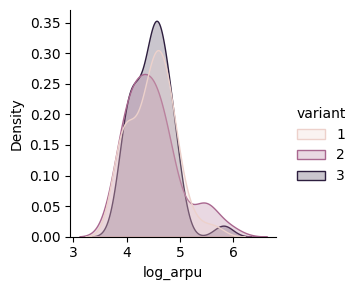

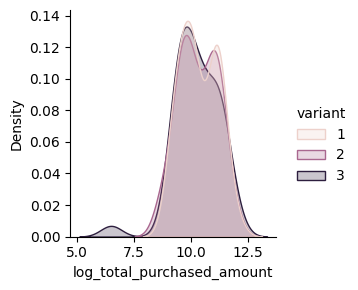

In [22]:
plot_kde(df_daily, "arpu")
plot_kde(df_daily, "total_purchased_amount")
plot_kde(apply_log_transform(df_daily, "arpu"), "log_arpu")
plot_kde(apply_log_transform(df_daily, "total_purchased_amount"), "log_total_purchased_amount")

In [23]:
print("""
Hypothesis Testing
    H0: There is no difference in daily arpu across variants.
    H1: At least one variant leads to significantly different daily arpu.
""")

##

print("""
      
      parametric anova one-way without log-transform for arpu
      """)

parametric_one_way_anova_test(df_daily, "arpu", log_transform=False)


print("""
      
      non parametric anova kruskal for arpu
      """)
non_parametric_anova_kruskal_test(df_daily, "arpu")



print("""
      
      parametric anova one-way with log-transform for arpu
      """)

parametric_one_way_anova_test(df_daily, "arpu", log_transform=True)


Hypothesis Testing
    H0: There is no difference in daily arpu across variants.
    H1: At least one variant leads to significantly different daily arpu.



      parametric anova one-way without log-transform for arpu
      
One-Way ANOVA  — F = 0.2838, p = 0.75343
Fail to reject H0: No significant difference between group means for 'arpu'.


      non parametric anova kruskal for arpu
      
H-score: 0.2320, p-value: 0.89045
Fail to reject the null hypothesis: no statistically significant difference found between group means for the arpu metric.


      parametric anova one-way with log-transform for arpu
      
One-Way ANOVA (log-transformed) — F = 0.0171, p = 0.98308
Fail to reject H0: No significant difference between group means for 'arpu'.


(np.float64(0.01707097665961235), np.float64(0.9830762168036155))

In [24]:
print("""
Hypothesis Testing
    H0: There is no difference in daily total purchase across variants.
    H1: At least one variant leads to significantly different daily total purchase.
""")

print("""
      
      parametric anova one-way without log-transform for total_purchased_amount
      """)

parametric_one_way_anova_test(df_daily, "total_purchased_amount", log_transform=False)


print("""
      
      non parametric anova kruskal for total_purchased_amount
      """)
non_parametric_anova_kruskal_test(df_daily, "total_purchased_amount")



print("""
      
      parametric anova one-way with log-transform for total_purchased_amount
      """)

parametric_one_way_anova_test(df_daily, "total_purchased_amount", log_transform=True)


Hypothesis Testing
    H0: There is no difference in daily total purchase across variants.
    H1: At least one variant leads to significantly different daily total purchase.



      parametric anova one-way without log-transform for total_purchased_amount
      
One-Way ANOVA  — F = 0.0338, p = 0.96681
Fail to reject H0: No significant difference between group means for 'total_purchased_amount'.


      non parametric anova kruskal for total_purchased_amount
      
H-score: 0.1428, p-value: 0.93107
Fail to reject the null hypothesis: no statistically significant difference found between group means for the total_purchased_amount metric.


      parametric anova one-way with log-transform for total_purchased_amount
      
One-Way ANOVA (log-transformed) — F = 0.2163, p = 0.80579
Fail to reject H0: No significant difference between group means for 'total_purchased_amount'.


(np.float64(0.2163103399496492), np.float64(0.8057885826435747))

## Answer to the Question-1

- First, I confirmed that all variants started at the same time and had similar cohort sizes. This avoids bias where a longer-lived variant might show higher total revenue just due to exposure time.

- Even though the cohorts were aligned, I still normalized by calculating ARPU to make fair comparisons.

- I didn’t see meaningful differences between variants in total purchases or ARPU. I also checked the Coefficient of Variation over time to monitor stability — variability levels stayed consistent. I used Levene’s test to confirm equal variance, and CoV as a supporting check.

- The data is right-skewed, as expected with monetary metrics. Even after log transformation, normality wasn’t ideal, but it was close. This put us in a grey zone between using Kruskal-Wallis and one-way ANOVA on the log-transformed data — so I ran both.

- All test results showed no statistically significant difference. If any test had shown a borderline result, I would have preferred the non-parametric one due to non-normality.

- Since the sample size was large and the p-values were clearly non-significant, I don’t believe we missed a real difference due to low power. That said, in a production version of this analysis, I would also include percent differences between group means and effect sizes like Cohen’s f or η² — especially for stakeholders who care about business impact, not just statistical significance.

## Question-2

User behavior difference between the different versions:

- Is there a difference in single purchase values?
- Is there a difference in number of purchases?

### Plan
- I’ll use user-level data for this part, since daily-level aggregation would ignore lifecycle differences between users.
- I’ll focus on two metrics:
  - purchases_per_day – to account for varying exposure duration
  - avg_purchase_amount – to approximate average spend per transaction

- Although the case asks about "purchase amount per transaction," I can’t calculate that directly without transaction-level data. So I use average purchase amount per user as the closest proxy.

- I’ll visualize distributions to understand spread and skew across variants.

- Then I’ll run normality and variance homogeneity tests:

  - If normality holds → ANOVA or Welch
  - If not → Kruskal-Wallis

- If significant differences are detected, I’ll follow up with post-hoc tests (Tukey for parametric, Dunn for non-parametric).

- I’ll also check group means and percent differences to assess practical impact.

In [25]:
df_user = df_clean.groupby(["user_id", "variant"])[["purchases", "total_purchased_amount", "date"]].agg(
    total_purchased_amount=("total_purchased_amount", "sum"),
    purchases=("purchases", "sum"),
    active_days = ("date", "count")
).reset_index()

df_user["purchases_per_day"] = df_user["purchases"] / df_user["active_days"]
df_user["avg_purchase_amount"] = df_user["total_purchased_amount"] / df_user["purchases"]

df_user.head()

,user_id,variant,total_purchased_amount,purchases,active_days,purchases_per_day,avg_purchase_amount
0,1,2,92.2,1317,4,329.25,0.070008
1,2,3,3.6,72,1,72.00,0.050000
2,3,1,3.9,54,1,54.00,0.072222
3,4,3,69.6,309,2,154.50,0.225243
4,5,1,23.2,213,4,53.25,0.108920


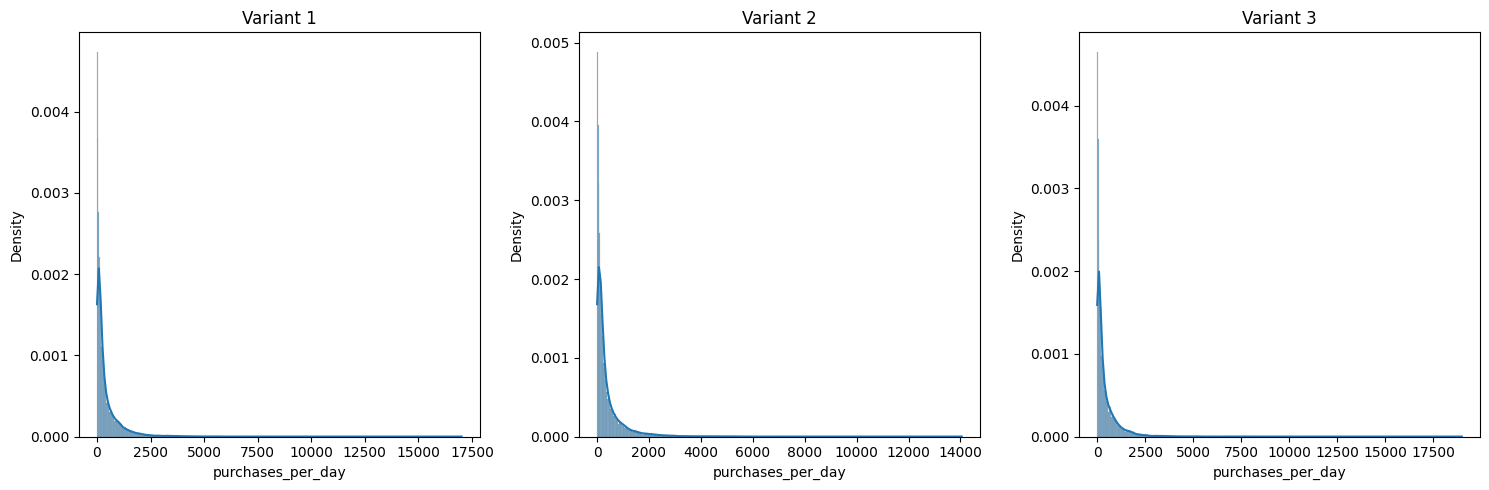

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.histplot(data=df_user[df_user["variant"] == i+1], x="purchases_per_day", kde=True, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Variant {i+1}") 
    ax.set_xlabel("purchases_per_day")  
    ax.set_ylabel("Density") 

plt.tight_layout()
plt.show()

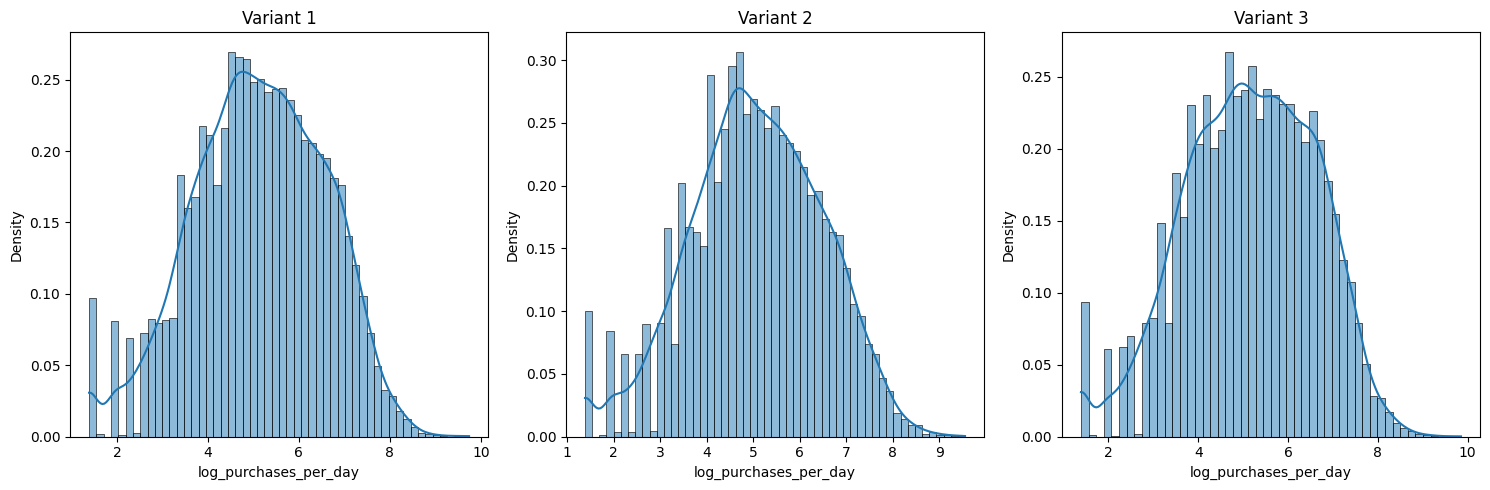

In [27]:
df_user_log = apply_log_transform(df_user, "purchases_per_day")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.histplot(data=df_user_log[df_user_log["variant"] == i+1], x="log_purchases_per_day", kde=True, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Variant {i+1}") 
    ax.set_xlabel("log_purchases_per_day")  
    ax.set_ylabel("Density") 

plt.tight_layout()
plt.show()

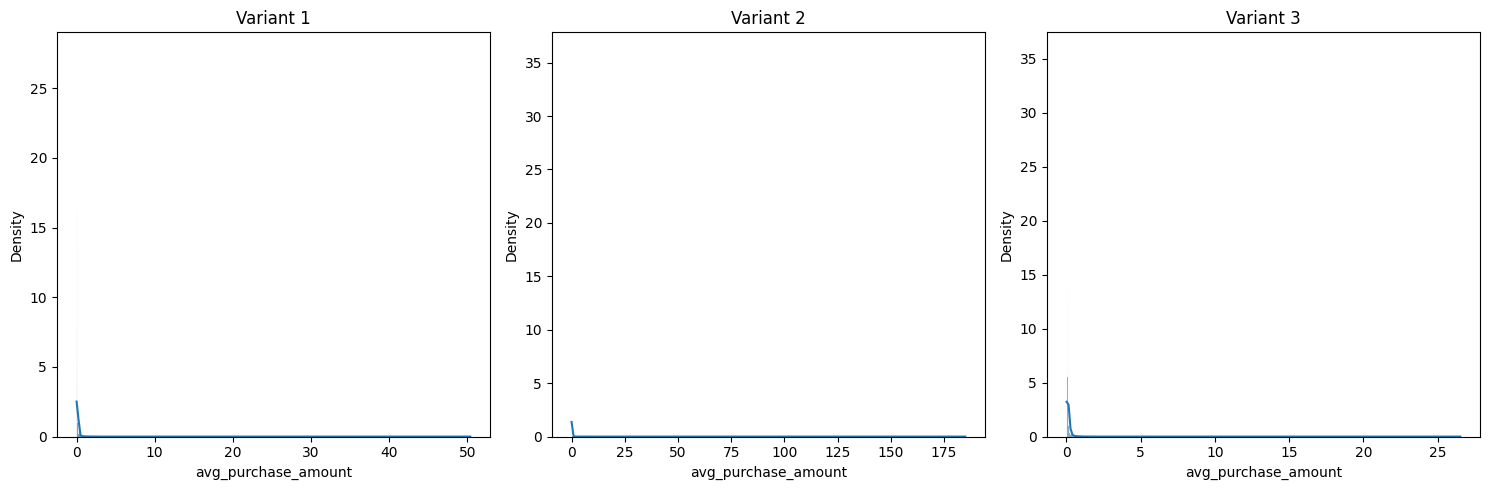

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.histplot(data=df_user[df_user["variant"] == i+1], x="avg_purchase_amount", kde=True, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Variant {i+1}") 
    ax.set_xlabel("avg_purchase_amount")  
    ax.set_ylabel("Density") 

plt.tight_layout()
plt.show()

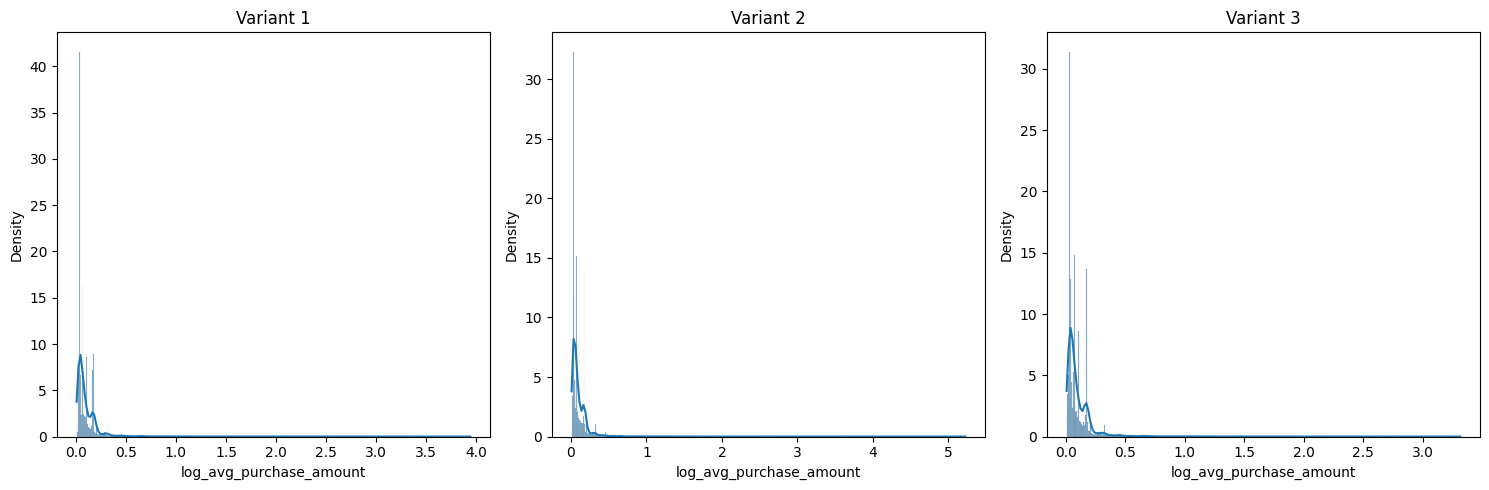

In [29]:
df_user_log = apply_log_transform(df_user, "avg_purchase_amount")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.histplot(data=df_user_log[df_user_log["variant"] == i+1], x="log_avg_purchase_amount", kde=True, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Variant {i+1}") 
    ax.set_xlabel("log_avg_purchase_amount")  
    ax.set_ylabel("Density") 

plt.tight_layout()
plt.show()

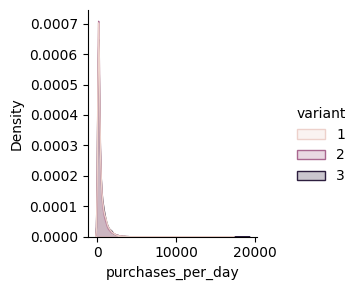

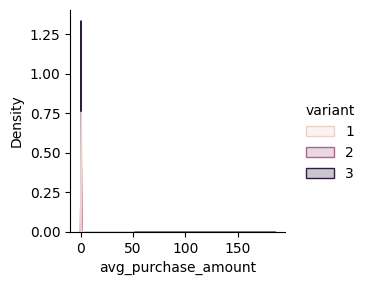

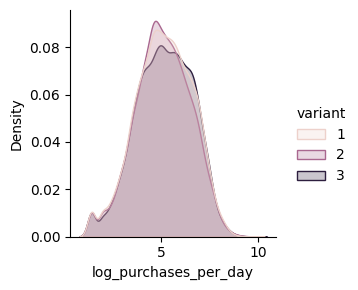

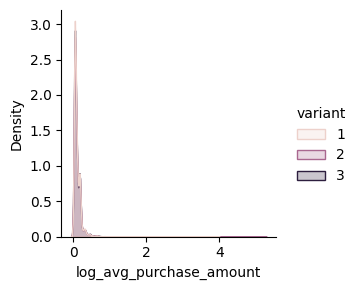

In [30]:
plot_kde(df_user, "purchases_per_day")
plot_kde(df_user, "avg_purchase_amount")
plot_kde(apply_log_transform(df_user, "purchases_per_day"), "log_purchases_per_day")
plot_kde(apply_log_transform(df_user, "avg_purchase_amount"), "log_avg_purchase_amount")

In [31]:
print("""

variance homogeneity before log-transform for purchases_per_day
""")
variance_homogeneity_test(df_user, "purchases_per_day")

print("""

variance homogeneity after log-transform for purchases_per_day
""")
variance_homogeneity_test(apply_log_transform(df_user, "purchases_per_day"), "log_purchases_per_day")

##

print("""

variance homogeneity before log-transform for avg_purchase_amount
""")
variance_homogeneity_test(df_user, "avg_purchase_amount")

print("""

variance homogeneity after log-transform for avg_purchase_amount
""")
variance_homogeneity_test(apply_log_transform(df_user, "avg_purchase_amount"), "log_avg_purchase_amount")



variance homogeneity before log-transform for purchases_per_day

Levene's Test: Score = 8.5712, p-value = 0.00019
The variances are NOT equal for the purchases_per_day.


variance homogeneity after log-transform for purchases_per_day

Levene's Test: Score = 12.6419, p-value = 0.00000
The variances are NOT equal for the log_purchases_per_day.


variance homogeneity before log-transform for avg_purchase_amount

Levene's Test: Score = 1.1066, p-value = 0.33069
The variances are equal for the avg_purchase_amount.


variance homogeneity after log-transform for avg_purchase_amount

Levene's Test: Score = 0.5996, p-value = 0.54905
The variances are equal for the log_avg_purchase_amount.


(np.float64(0.5995686027585633), np.float64(0.549052511660512))

In [32]:
print("""
Hypothesis Testing
    H0: There is no difference in purchases per day in user-level across variants.
    H1: At least one variant leads to significantly different purchases per day in user-level across variants.
""")

print("""
      non parametric anova klusker test  for purchases_per_day
      """)

non_parametric_anova_kruskal_test(df_user, "purchases_per_day")


Hypothesis Testing
    H0: There is no difference in purchases per day in user-level across variants.
    H1: At least one variant leads to significantly different purchases per day in user-level across variants.


      non parametric anova klusker test  for purchases_per_day
      
H-score: 34.3586, p-value: 0.00000
Reject the null hypothesis: at least one group mean is significantly different for the purchases_per_day metric.


(np.float64(34.358607577451394), np.float64(3.460374967219854e-08))

In [33]:
df_user.groupby("variant")[["purchases_per_day"]].describe()

purchases_per_day                                                     \
                    count        mean         std  min   25%    50%      75%   
variant                                                                        
1                 16595.0  408.684944  663.778840  3.0  60.0  168.0  490.875   
2                 15931.0  387.024435  657.840939  3.0  60.0  156.0  438.000   
3                 15987.0  419.241580  664.638233  3.0  60.0  177.0  522.000   

                  
             max  
variant           
1        17016.0  
2        14046.0  
3        18975.0

In [34]:
print(posthoc_nonparametric(df_user, "purchases_per_day"))

print(posthoc_parametric(df_user, "purchases_per_day"))

          1             2             3
1  1.000000  8.559419e-04  7.647563e-02
2  0.000856  1.000000e+00  1.915799e-08
3  0.076476  1.915799e-08  1.000000e+00
          2         3         1
2  1.000000  0.000041  0.008941
3  0.000041  1.000000  0.321005
1  0.008941  0.321005  1.000000


In [35]:
import warnings 

warnings.filterwarnings("ignore")

group_means = df_user.groupby("variant")["purchases_per_day"].mean()
baseline = group_means[1]
pct_diff_vs_1 = (group_means - baseline) / baseline * 100
print(pct_diff_vs_1.round(2))

variant
1    5.60
2    0.00
3    8.32
Name: purchases_per_day, dtype: float64


In [36]:
group_means = df_user.groupby("variant")["purchases_per_day"].mean()
baseline = group_means[0]
pct_diff_vs_1 = (group_means - baseline) / baseline * 100

pct_diff_vs_1

variant
1    0.000000
2   -5.300051
3    2.583074
Name: purchases_per_day, dtype: float64

In [37]:
print("""
Hypothesis Testing
    H0: There is no difference in avg_purchase?amount in user-level across variants.
    H1: At least one variant leads to significantly different avg_purchase?amount in user-level across variants.
""")

print("""
      non parametric anova klusker test  for avg_purchase?amount
      """)

non_parametric_anova_kruskal_test(df_user, "avg_purchase_amount")


Hypothesis Testing
    H0: There is no difference in avg_purchase?amount in user-level across variants.
    H1: At least one variant leads to significantly different avg_purchase?amount in user-level across variants.


      non parametric anova klusker test  for avg_purchase?amount
      
H-score: 2.2901, p-value: 0.31821
Fail to reject the null hypothesis: no statistically significant difference found between group means for the avg_purchase_amount metric.


(np.float64(2.290097964688533), np.float64(0.3182083308186705))

## Answer to the Question-2

- Normality is violated for both metrics, even after log transformation. 
- Variances are equal after log-transformation, but distributions are still skewed, so I went with a non-parametric test.

- For purchases per day, Variant 2 is significantly lower than the others.
  - I ran post-hoc tests, and the difference is statistically significant.

- Variant 2 users made ~5% fewer purchases per day compared to Variant 1.
  - This isn’t just statistical noise — it’s a clear behavioral drop.

- On the other hand, when looking at average purchase amount, there’s no significant difference between variants.
  - Users in Variant 2 aren’t spending less per transaction — they’re just buying less often.

- So this is a frequency problem, not a value problem.

## Question-3 
**Difference in Retention Rates?**

### Plan

- I create a structured and dynamic retention dataset, so it can be reused or plugged into BI tools later.

- I calculate 3 types of retention:
    - Cohort retention (did the user come back?)
    - Purchase retention (did the user make a purchase again?)
    - Revenue retention (did the user generate more revenue?)

- I use cumulative retention curves to see long-term patterns over time.

- I make sure each cohort has enough users and that cohort sizes are balanced across variants to avoid skewed comparisons.

- I only include mature cohorts — users who have at least 21 days in the test — so I can reliably track retention over time.

- I visualize retention by variant to see which one performs better over time.

- To back this up, I compare rolling 7-, 14-, and 21-day retention rates across variants — helps cross-check what I see in the visuals.

In [38]:
df_retentions = duckdb.query("""
                             
-- find first txs of people
with first_transactions as (
  	select 
		user_id, 
		variant, 
		min(date)::date as first_transaction_date
	from df_clean
	group by 1, 2
)
-- focus on mature cohorts having at least 21 days since their first trx
, completed_cohorts as (
	select *
	from first_transactions 
	where first_transaction_date <= (select max(date) from df_clean)::date - 21
)
-- avoid filtering out dates due to cohorts not having tx on specific days
, keys as (
	select * 
	from completed_cohorts
	cross join (
		select 
            range as days_since_first_transaction 
    	from range(0, 22)
	)
) 
-- calculate people's actions based on their first tx date over time.
, user_retentions as (
	select 
		variant,
		user_id,
		first_transaction_date, 
		days_since_first_transaction,
		coalesce(purchases, 0) as purchases,
		coalesce(total_purchased_amount, 0) as total_purchased_amount
	from keys 
	left join (
		select
			cc.variant,
			cc.user_id,
			cc.first_transaction_date, 
			(cast(t.date as date) - cast(cc.first_transaction_date as date)) as days_since_first_transaction,
			sum(purchases) as purchases,
			sum(total_purchased_amount) as total_purchased_amount
		from completed_cohorts cc
		join df_clean t 
			on cc.user_id = t.user_id
		group by 1,2,3,4
	) actual_retentions
	using (variant, user_id, first_transaction_date, days_since_first_transaction)
) 
-- group by cohorts, not user-levl anymore
, cohort_retentions as (
	select 
		variant::numeric as variant,
		first_transaction_date::date as first_transaction_date,
		days_since_first_transaction, 
		count(case when purchases > 0 then user_id end) as retained_users,
		coalesce(sum(case when days_since_first_transaction = 0 then purchases end), 0) as first_transaction_purchases,
		sum(purchases) as retained_purchases, 
		sum(total_purchased_amount) as retained_total_purchased_amount
	from user_retentions 
	group by 1, 2, 3
)
-- to calculate the ret rates, find cohorts' initial figures
, cohort_sizes as (
    select
        variant::numeric as variant,
        first_transaction_date::date as first_transaction_date,
        count(distinct user_id) as cohort_size,
        sum(purchases) as first_transaction_purchases,
        sum(total_purchased_amount) as first_transaction_total_purchased_amount
    from user_retentions
    where days_since_first_transaction = 0
    group by 1, 2
)
-- calc ret rates.
, retention_rates as (
	select
	    c.variant,
	    c.first_transaction_date,
	    c.days_since_first_transaction,
	    c.retained_users,
	    cs.cohort_size,
	    c.retained_users / cs.cohort_size as cohort_retention_rate,
	    c.retained_purchases / cs.first_transaction_purchases as purchases_retention_rate,
	    c.retained_total_purchased_amount / cs.first_transaction_total_purchased_amount as total_purchased_amount_retention_rate
	from cohort_retentions c
	join cohort_sizes cs
	  using (variant, first_transaction_date)
) 
-- calc cumulative ret rates to showcase the retention curves.
, cumulative_retention_rates as (
	select *, 
		sum(cohort_retention_rate) over(partition by variant, first_transaction_date order by days_since_first_transaction) as cumulative_cohort_retention_rate,
		sum(purchases_retention_rate) over(partition by variant, first_transaction_date order by days_since_first_transaction) as cumulative_purchases_retention_rate,
		sum(total_purchased_amount_retention_rate) over(partition by variant, first_transaction_date order by days_since_first_transaction) as cumulative_total_purchased_amount_retention_rate
	from retention_rates
)
select * 
from cumulative_retention_rates
                             
""").to_df()

df_retentions.head(10)

,variant,first_transaction_date,days_since_first_transaction,retained_users,cohort_size,cohort_retention_rate,purchases_retention_rate,total_purchased_amount_retention_rate,cumulative_cohort_retention_rate,cumulative_purchases_retention_rate,cumulative_total_purchased_amount_retention_rate
0,1.0,2024-04-14,0,109,109,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.0,2024-04-14,1,17,109,0.155963,0.414293,0.287153,1.155963,1.414293,1.287153
2,1.0,2024-04-14,2,7,109,0.064220,0.055243,0.027922,1.220183,1.469536,1.315075
3,1.0,2024-04-14,3,9,109,0.082569,0.037744,0.011296,1.302752,1.507281,1.326372
4,1.0,2024-04-14,4,6,109,0.055046,0.276600,0.267761,1.357798,1.783880,1.594132
5,1.0,2024-04-14,5,2,109,0.018349,0.039469,0.016639,1.376147,1.823349,1.610771
6,1.0,2024-04-14,6,8,109,0.073394,0.204305,0.118880,1.449541,2.027654,1.729651
7,1.0,2024-04-14,7,5,109,0.045872,0.003449,0.002473,1.495413,2.031102,1.732125
8,1.0,2024-04-14,8,13,109,0.119266,0.208839,0.106360,1.614679,2.239941,1.838484
9,1.0,2024-04-14,9,3,109,0.027523,0.026440,0.012406,1.642202,2.266381,1.850890


<Axes: title={'center': 'Cohort Size by Date and Variant'}, xlabel='first_transaction_date'>

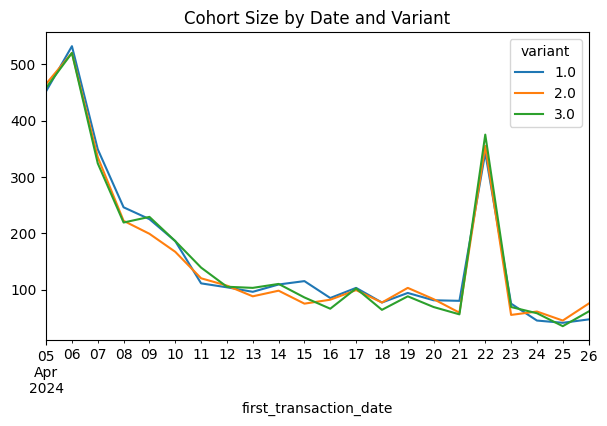

In [39]:
df_retentions.groupby(["variant", "first_transaction_date"])["cohort_size"].mean().to_frame().reset_index().pivot(
    index="first_transaction_date", columns="variant", values="cohort_size"
).plot(figsize=(7, 4), title="Cohort Size by Date and Variant")

In [40]:
df_retentions.groupby(["variant", "first_transaction_date"])["cohort_size"].mean().to_frame().reset_index().pivot(
    index="first_transaction_date", columns="variant", values="cohort_size"
)

variant,1.0,2.0,3.0
first_transaction_date,,,
2024-04-05,452.0,465.0,458.0
2024-04-06,532.0,520.0,520.0
2024-04-07,349.0,335.0,324.0
2024-04-08,246.0,222.0,219.0
2024-04-09,225.0,199.0,229.0
2024-04-10,186.0,167.0,186.0
2024-04-11,111.0,120.0,139.0
2024-04-12,104.0,107.0,105.0
2024-04-13,96.0,88.0,103.0


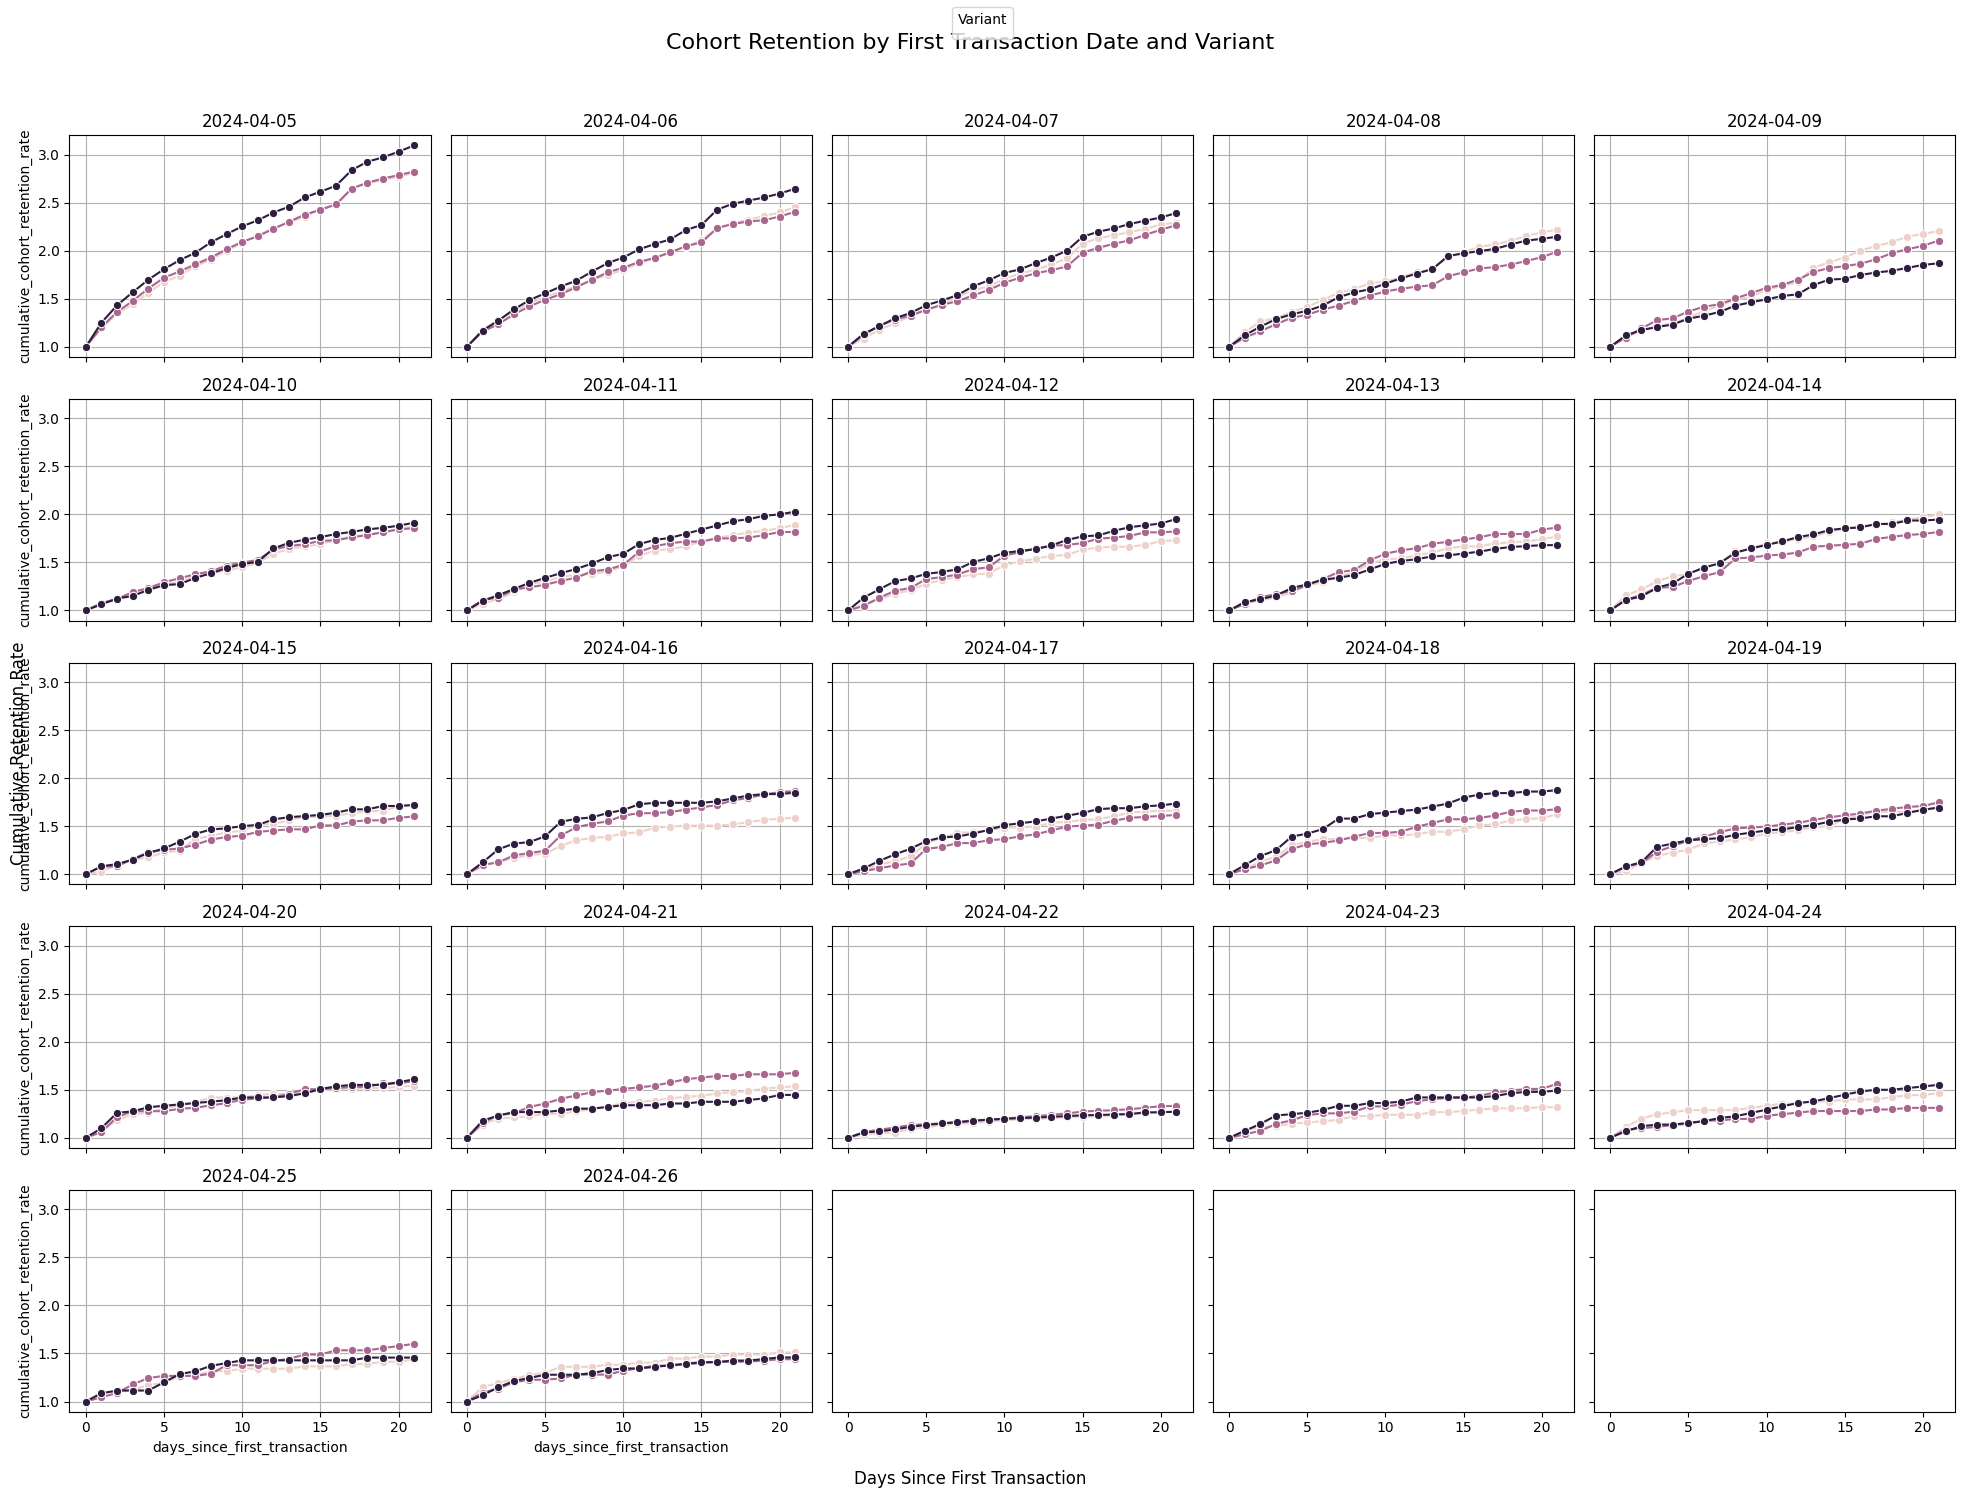

In [41]:
cohort_dates = sorted(df_retentions['first_transaction_date'].unique())

n_rows, n_cols = 5, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

for i, cohort_date in enumerate(cohort_dates):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    subset = df_retentions[df_retentions['first_transaction_date'] == cohort_date]

    sns.lineplot(
        data=subset,
        x="days_since_first_transaction",
        y="cumulative_cohort_retention_rate",
        hue="variant",
        marker="o",
        ax=ax,
        legend=False  
    )

    ax.set_title(cohort_date.strftime("%Y-%m-%d"))
    ax.grid(True)

fig.suptitle("Cohort Retention by First Transaction Date and Variant", fontsize=16)
fig.supxlabel("Days Since First Transaction")
fig.supylabel("Cumulative Retention Rate")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, title="Variant")

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

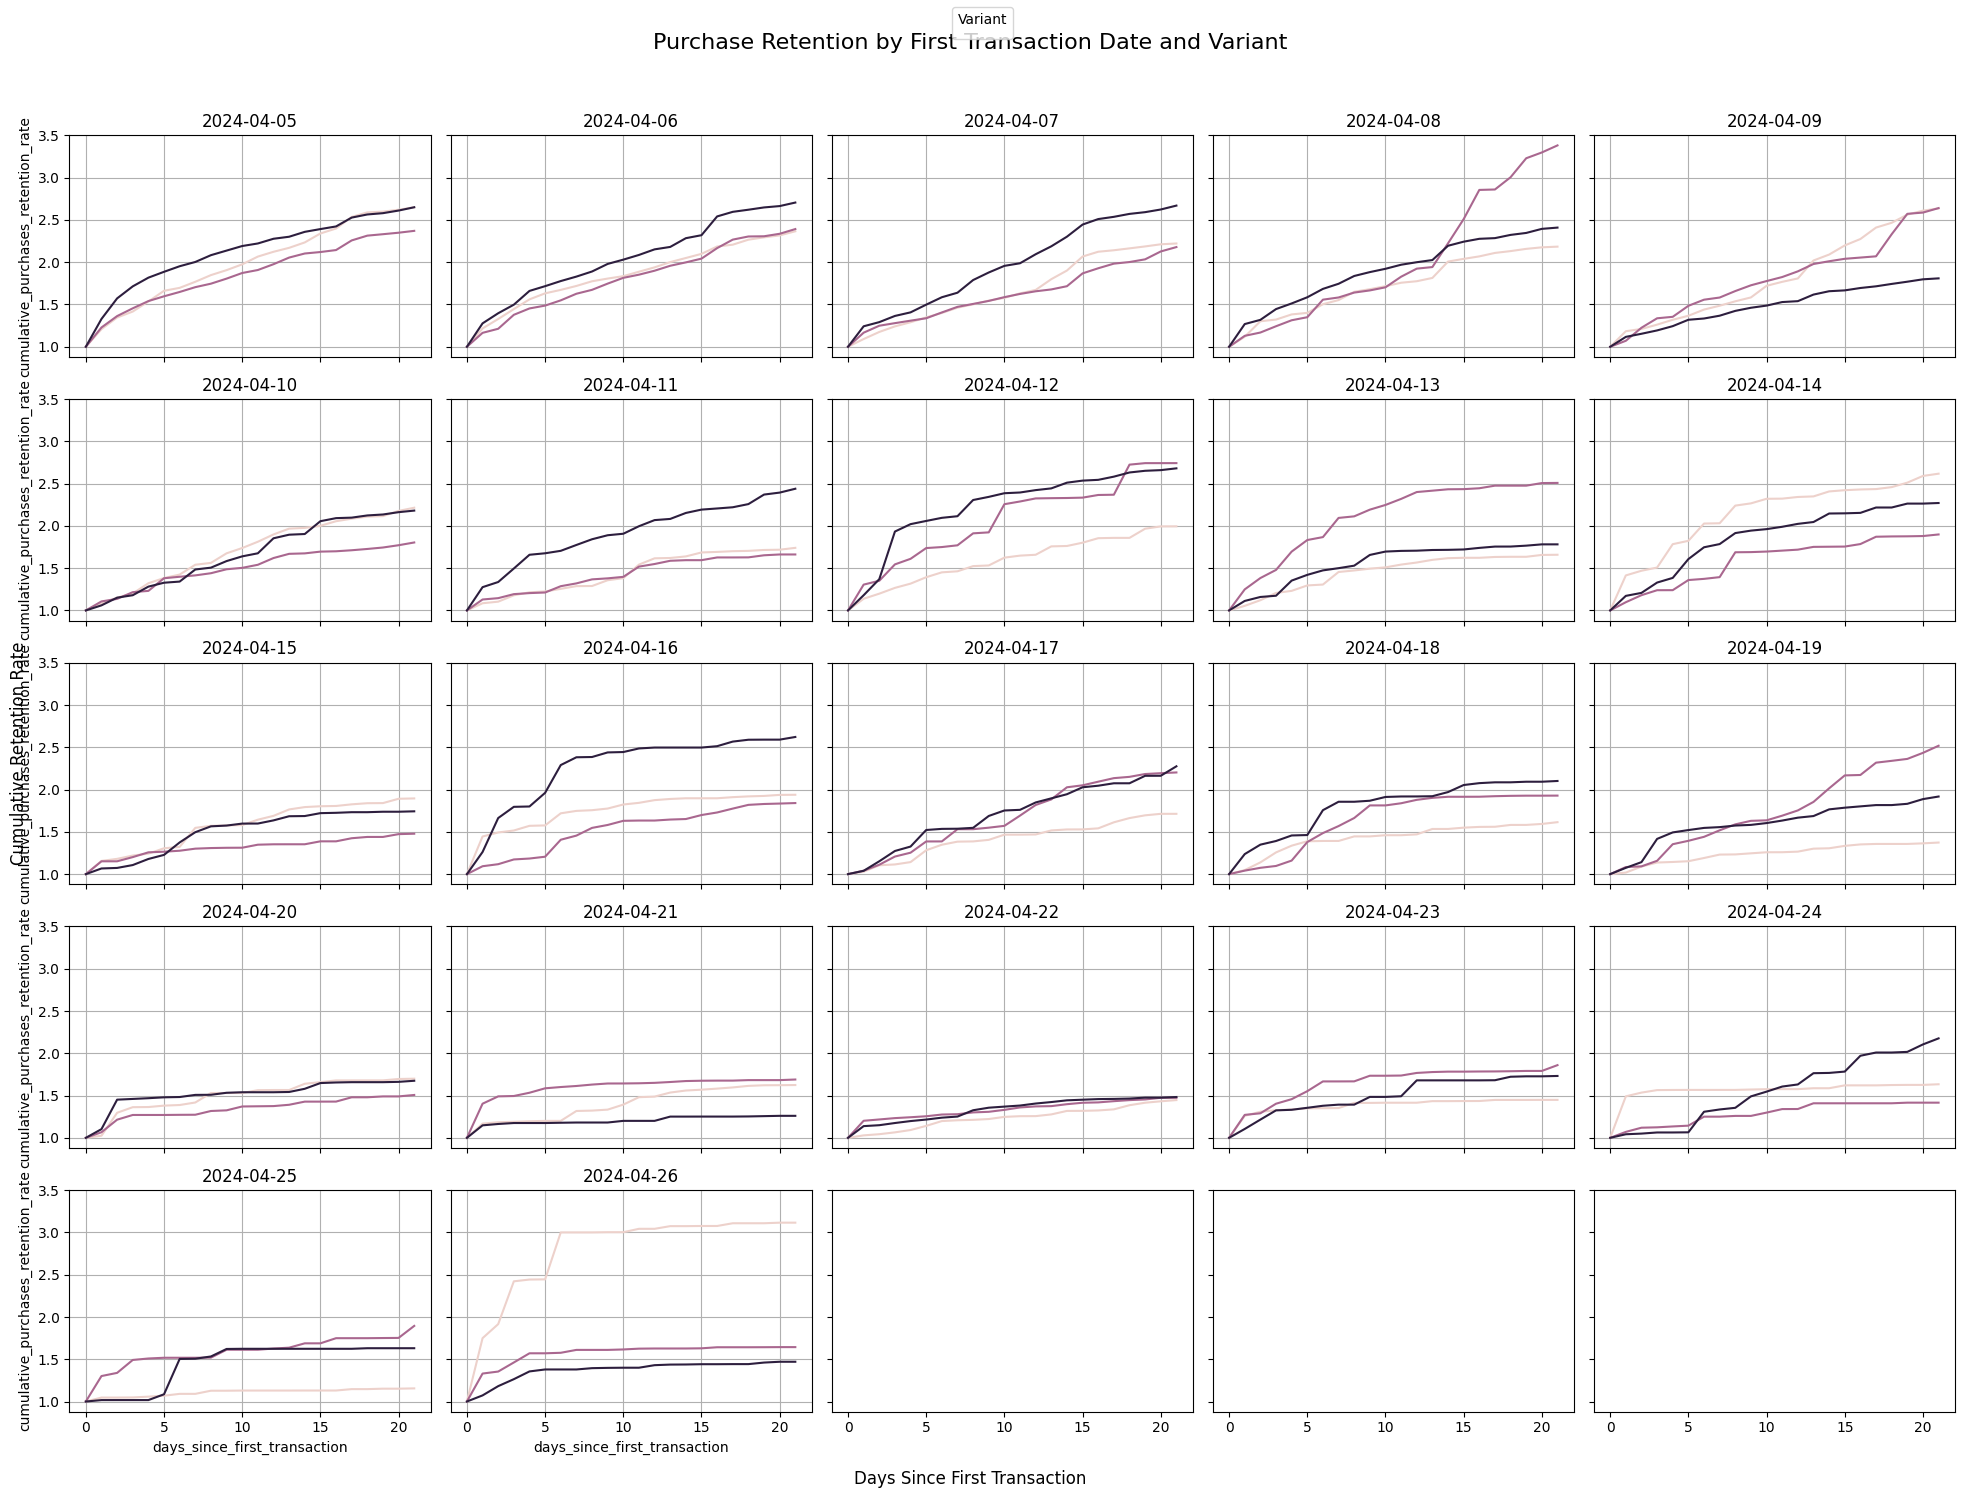

In [42]:
n_rows, n_cols = 5, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

for i, cohort_date in enumerate(cohort_dates):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    subset = df_retentions[df_retentions['first_transaction_date'] == cohort_date]

    sns.lineplot(
        data=subset,
        x="days_since_first_transaction",
        y="cumulative_purchases_retention_rate",
        hue="variant",
        ax=ax,
        legend=False  
    )

    ax.set_title(cohort_date.strftime("%Y-%m-%d"))
    ax.grid(True)

fig.suptitle("Purchase Retention by First Transaction Date and Variant", fontsize=16)
fig.supxlabel("Days Since First Transaction")
fig.supylabel("Cumulative Retention Rate")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, title="Variant")

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

In [43]:
avg_cumulative_retention_rates = duckdb.query("""
	with day_7 as (
		select * 
		from df_retentions 
		where days_since_first_transaction = 7 
	)
	, day_14 as (
		select * 
		from df_retentions 
		where days_since_first_transaction = 14 
	)
	, day_21 as (
		select * 
		from df_retentions 
		where days_since_first_transaction = 21
	)
	, together as (
		select 
			t1.variant,
			t1.first_transaction_date, 
			t1.cumulative_cohort_retention_rate as day_7_cohort_cum_rate,
			t2.cumulative_cohort_retention_rate as day_14_cohort_cum_rate,
			t3.cumulative_cohort_retention_rate as day_21_cohort_cum_rate,
			
			t1.cumulative_purchases_retention_rate as day_7_purchases_cum_rate,
			t2.cumulative_purchases_retention_rate as day_14_purchases_cum_rate,
			t3.cumulative_purchases_retention_rate as day_21_purchases_cum_rate,
			
			t1.cumulative_total_purchased_amount_retention_rate as day_7_total_purchased_amount_cum_rate,
			t2.cumulative_total_purchased_amount_retention_rate as day_14_total_purchased_amount_cum_rate,
			t3.cumulative_total_purchased_amount_retention_rate as day_21_total_purchased_amount_cum_rate
		from day_7 as t1 
		left join day_14 as t2 
			on t1.variant = t2.variant and t1.first_transaction_date = t2.first_transaction_date 
		left join day_21 as t3
			on t1.variant = t3.variant and t1.first_transaction_date = t3.first_transaction_date 
	)
	select 
		variant,
		avg(day_7_cohort_cum_rate) as avg_day_7_cum_cohort_ret_rate,
		avg(day_14_cohort_cum_rate) as avg_day_14_cum_cohort_ret_rate,
		avg(day_21_cohort_cum_rate) as avg_day_21_cum_cohort_ret_rate,
		
		avg(day_7_purchases_cum_rate) as avg_day_7_cum_purchases_ret_rate,
		avg(day_14_purchases_cum_rate) as avg_day_14_cum_purchases_ret_rate,
		avg(day_21_purchases_cum_rate) as avg_day_21_cum_purchases_ret_rate,
		
		avg(day_7_total_purchased_amount_cum_rate) as avg_day_7_total_purchased_amount_cum_rate,
		avg(day_14_total_purchased_amount_cum_rate) as avg_day_14_total_purchased_amount_cum_rate,
		avg(day_21_total_purchased_amount_cum_rate) as avg_day_21_total_purchased_amount_cum_rate
	from together
	group by 1 
""").to_df()   

<Axes: ylabel='variant'>

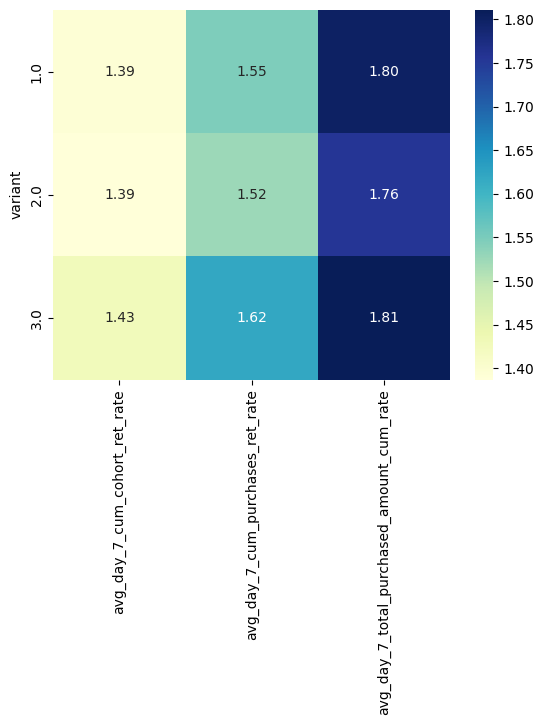

In [44]:
sns.heatmap(data = avg_cumulative_retention_rates.groupby("variant")[["avg_day_7_cum_cohort_ret_rate", "avg_day_7_cum_purchases_ret_rate", "avg_day_7_total_purchased_amount_cum_rate"]].sum(), annot= True, cmap="YlGnBu", fmt=".2f")

<Axes: ylabel='variant'>

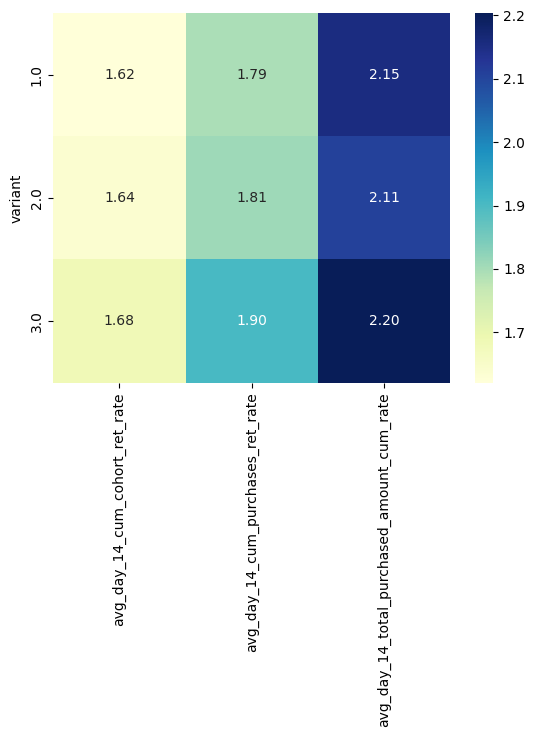

In [45]:
sns.heatmap(data = avg_cumulative_retention_rates.groupby("variant")[["avg_day_14_cum_cohort_ret_rate", "avg_day_14_cum_purchases_ret_rate", "avg_day_14_total_purchased_amount_cum_rate"]].sum(), annot= True, cmap="YlGnBu", fmt=".2f")

<Axes: ylabel='variant'>

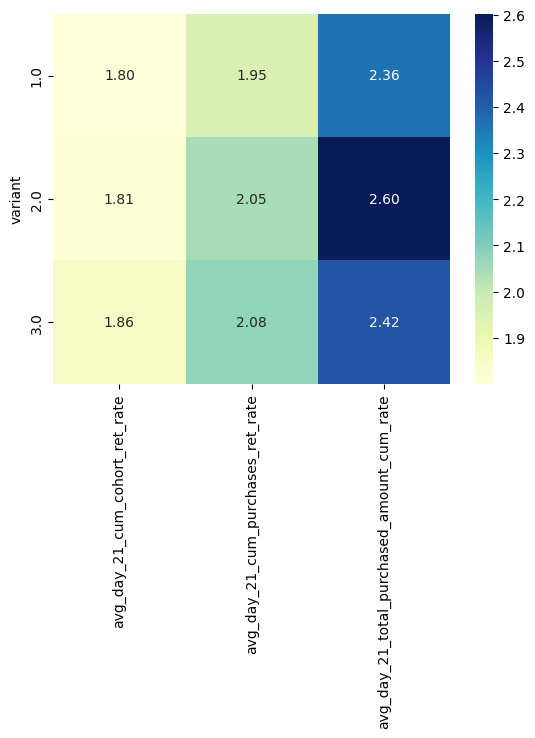

In [46]:
sns.heatmap(data = avg_cumulative_retention_rates.groupby("variant")[["avg_day_21_cum_cohort_ret_rate", "avg_day_21_cum_purchases_ret_rate", "avg_day_21_total_purchased_amount_cum_rate"]].sum(), annot= True, cmap="YlGnBu", fmt=".2f")

In [47]:
df_aggregated_average_retention_rates = duckdb.query("""
select 
	variant,
	days_since_first_transaction,
	avg(cumulative_cohort_retention_rate) as avg_cumulative_cohort_retention_rate,
	avg(cumulative_purchases_retention_rate) as avg_cumulative_purchases_retention_rate,
	avg(cumulative_total_purchased_amount_retention_rate) as avg_cumulative_total_purchased_amount_retention_rate
from df_retentions
group by 1,2
""").to_df()

<Axes: xlabel='days_since_first_transaction', ylabel='avg_cumulative_cohort_retention_rate'>

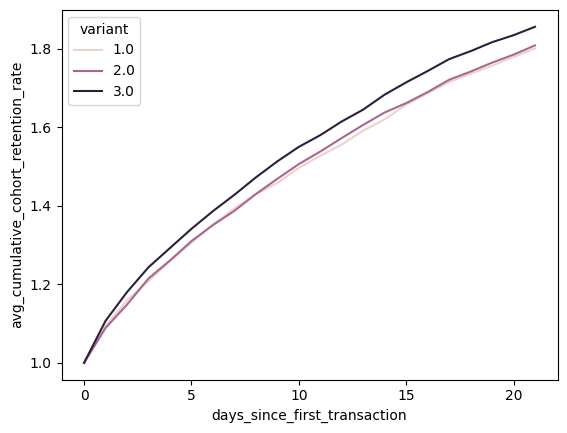

In [48]:
sns.lineplot(
    data=df_aggregated_average_retention_rates,
    x="days_since_first_transaction",
    y="avg_cumulative_cohort_retention_rate",
    hue="variant",
)

<Axes: xlabel='days_since_first_transaction', ylabel='avg_cumulative_purchases_retention_rate'>

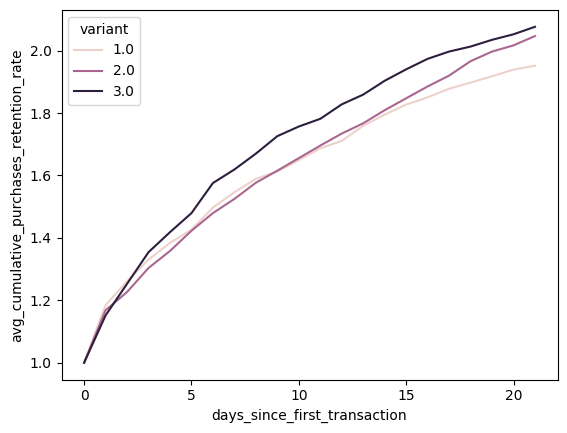

In [49]:
sns.lineplot(
    data=df_aggregated_average_retention_rates,
    x="days_since_first_transaction",
    y="avg_cumulative_purchases_retention_rate",
    hue="variant",
)

<Axes: xlabel='days_since_first_transaction', ylabel='avg_cumulative_total_purchased_amount_retention_rate'>

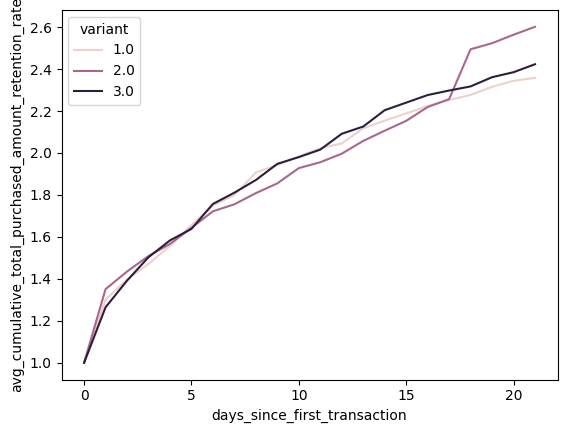

In [50]:
sns.lineplot(
    data=df_aggregated_average_retention_rates,
    x="days_since_first_transaction",
    y="avg_cumulative_total_purchased_amount_retention_rate",
    hue="variant",
)

In [51]:
df_aggregated_average_retention_rates[df_aggregated_average_retention_rates["days_since_first_transaction"] == 21]

,variant,days_since_first_transaction,avg_cumulative_cohort_retention_rate,avg_cumulative_purchases_retention_rate,avg_cumulative_total_purchased_amount_retention_rate
28,3.0,21,1.855917,2.076432,2.422858
47,2.0,21,1.808532,2.046786,2.601394
61,1.0,21,1.800691,1.951853,2.357777


In [52]:
df_rolling_retentions = duckdb.query("""
-- find first txs of people
with first_transactions as (
  	select 
		user_id, 
		variant, 
		min(date)::date as first_transaction_date
	from df_clean
	group by 1, 2
)
-- focus on mature cohorts having at least 14 days since their first trx
, completed_cohorts as (
	select *
	from first_transactions 
	where first_transaction_date <= (select max(date) from df_clean)::date - 14
)
-- avoid filtering out dates due to cohorts not having tx on specific days
, keys as (
	select * 
	from completed_cohorts
	cross join (
		select range as days_since_first_transaction from range(0, 15)

	)
) 
-- calculate people's actions based on their first tx date over time.
, user_retentions as (
	select 
		variant,
		user_id,
		first_transaction_date, 
		days_since_first_transaction,
		coalesce(purchases, 0) as purchases,
		coalesce(total_purchased_amount, 0) as total_purchased_amount,
		case when coalesce(purchases, 0) > 0 then 1 else 0 end as active_flag
	from keys 
	left join (
		select
			cc.variant,
			cc.user_id,
			cc.first_transaction_date, 
			(cast(t.date as date) - cast(cc.first_transaction_date as date)) as days_since_first_transaction,
			sum(purchases) as purchases,
			sum(total_purchased_amount) as total_purchased_amount
		from completed_cohorts cc
		join df_clean t 
			on cc.user_id = t.user_id
		group by 1,2,3,4
	) actual_retentions
	using (variant, user_id, first_transaction_date, days_since_first_transaction)
) 
, windowed as (
	select 
		variant,
	    user_id,
	    first_transaction_date,
	    days_since_first_transaction,
	    sum(active_flag) over(partition by variant, user_id, first_transaction_date order by days_since_first_transaction rows between 6 preceding and current row) as rolling_7day_active_count,
		sum(active_flag) over(partition by variant, user_id, first_transaction_date order by days_since_first_transaction rows between 13 preceding and current row) as rolling_14day_active_count
	from user_retentions
)

, rolling_agg as (
  select
    variant,
    first_transaction_date,
    days_since_first_transaction,
    count(distinct user_id) filter (where rolling_7day_active_count >= 3) as rolling_7d_3d_retained_users,
	count(distinct user_id) filter (where rolling_7day_active_count >= 4) as rolling_7d_4d_retained_users,
	count(distinct user_id) filter (where rolling_14day_active_count >= 3) as rolling_14d_3d_retained_users,
	count(distinct user_id) filter (where rolling_14day_active_count >= 7) as rolling_14d_7d_retained_users,
	count(distinct user_id) filter (where rolling_14day_active_count >= 11) as rolling_14d_11d_retained_users,
	count(distinct user_id) filter (where rolling_14day_active_count >= 14) as rolling_14d_14d_retained_users,
    count(distinct user_id) as cohort_size
  from windowed
  group by 1, 2, 3
)

select
  *,
    rolling_7d_3d_retained_users / cohort_size as rolling_7d_3d_retention_rate,
	rolling_7d_4d_retained_users / cohort_size as rolling_7d_4d_retention_rate,
	rolling_14d_3d_retained_users / cohort_size as rolling_14d_3d_retention_rate,
	rolling_14d_7d_retained_users / cohort_size as rolling_14d_7d_retention_rate,
	rolling_14d_11d_retained_users / cohort_size as rolling_14d_11d_retention_rate,
	rolling_14d_14d_retained_users / cohort_size as rolling_14d_14d_retention_rate,
from rolling_agg
order by first_transaction_date, variant, days_since_first_transaction

""").to_df()

In [53]:
df_rolling_retentions

,variant,first_transaction_date,days_since_first_transaction,rolling_7d_3d_retained_users,rolling_7d_4d_retained_users,rolling_14d_3d_retained_users,rolling_14d_7d_retained_users,rolling_14d_11d_retained_users,rolling_14d_14d_retained_users,cohort_size,rolling_7d_3d_retention_rate,rolling_7d_4d_retention_rate,rolling_14d_3d_retention_rate,rolling_14d_7d_retention_rate,rolling_14d_11d_retention_rate,rolling_14d_14d_retention_rate
0,1,2024-04-05,0,0,0,0,0,0,0,452,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,1,2024-04-05,1,0,0,0,0,0,0,452,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,1,2024-04-05,2,27,0,27,0,0,0,452,0.059735,0.000000,0.059735,0.0,0.0,0.0
3,1,2024-04-05,3,39,9,39,0,0,0,452,0.086283,0.019912,0.086283,0.0,0.0,0.0
4,1,2024-04-05,4,53,19,53,0,0,0,452,0.117257,0.042035,0.117257,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,3,2024-05-03,10,0,0,1,0,0,0,19,0.000000,0.000000,0.052632,0.0,0.0,0.0
1301,3,2024-05-03,11,0,0,1,0,0,0,19,0.000000,0.000000,0.052632,0.0,0.0,0.0
1302,3,2024-05-03,12,0,0,1,0,0,0,19,0.000000,0.000000,0.052632,0.0,0.0,0.0
1303,3,2024-05-03,13,0,0,1,0,0,0,19,0.000000,0.000000,0.052632,0.0,0.0,0.0


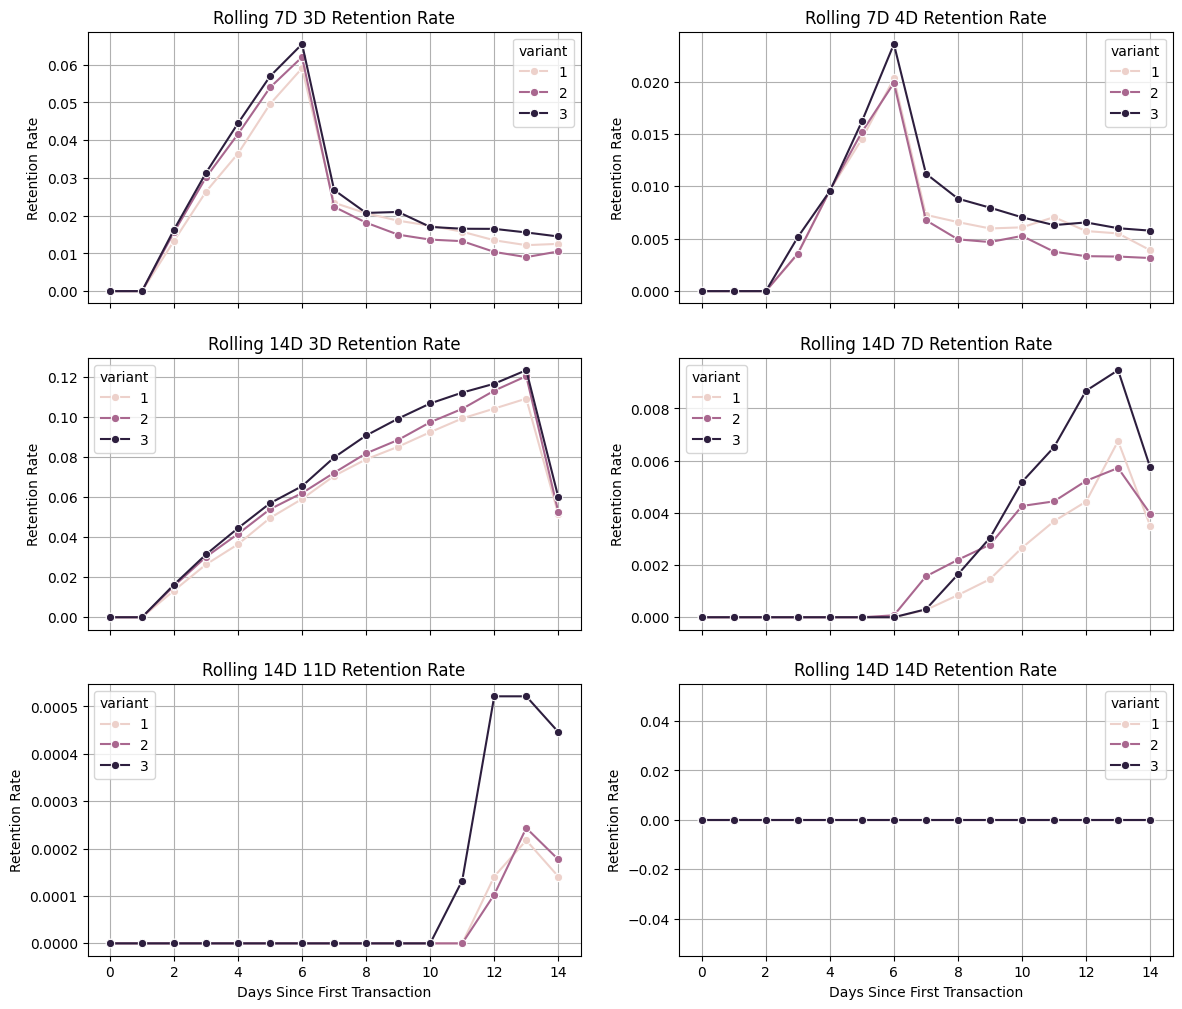

In [54]:
metrics = [
    "rolling_7d_3d_retention_rate",
    "rolling_7d_4d_retention_rate",
    "rolling_14d_3d_retention_rate",
    "rolling_14d_7d_retention_rate",
    "rolling_14d_11d_retention_rate",
    "rolling_14d_14d_retention_rate",
]


n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 12), sharex=True)


for i, metric in enumerate(metrics):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    sns.lineplot(
        data=df_rolling_retentions.groupby(["variant", "days_since_first_transaction"])[metric].mean().reset_index(),
        x="days_since_first_transaction",
        y=metric,
        hue="variant", 
        ci=None,
        marker='o',
        ax=ax
    )

    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("Days Since First Transaction")
    ax.set_ylabel("Retention Rate")
    ax.grid(True)


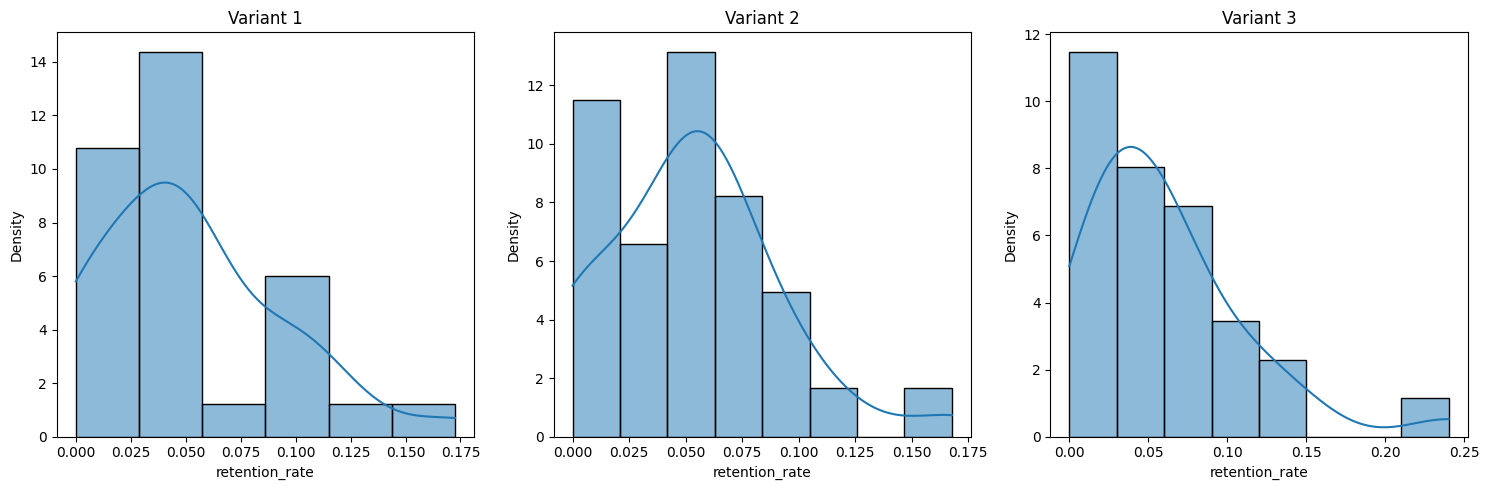

In [55]:
df_retention_test = df_rolling_retentions[df_rolling_retentions["days_since_first_transaction"] == 14].\
                                                groupby(["variant", "first_transaction_date"])[["rolling_14d_3d_retention_rate"]].sum().reset_index()

df_retention_test = df_retention_test.rename(columns={"rolling_14d_3d_retention_rate": "retention_rate"}) 




fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.histplot(data=df_retention_test[df_retention_test["variant"] == i+1], x="retention_rate", kde=True, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Variant {i+1}") 
    ax.set_xlabel("retention_rate")  
    ax.set_ylabel("Density") 

plt.tight_layout()
plt.show()


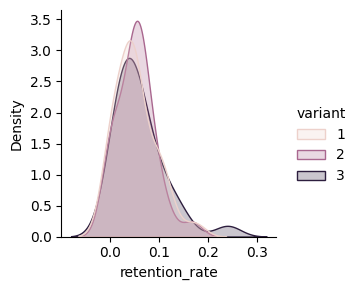

In [56]:
plot_kde(df_retention_test, "retention_rate")

In [57]:
print("""

variance homogeneity for retention_raqte
""")
variance_homogeneity_test(df_retention_test, "retention_rate")



variance homogeneity for retention_raqte

Levene's Test: Score = 0.5042, p-value = 0.60582
The variances are equal for the retention_rate.


(np.float64(0.5041690300589944), np.float64(0.6058232502199759))

In [58]:
print("""
Hypothesis Testing
    H0: There is no difference in rolling_14d_3d_retention_rates on the 14th day across variants.
    H1: There is significant difference in rolling_14d_3d_retention_rates on the 14th day across variants.
""")

df_retention_test = df_rolling_retentions[df_rolling_retentions["days_since_first_transaction"] == 14].\
                                                groupby(["variant", "first_transaction_date"])[["rolling_14d_3d_retention_rate"]].sum().reset_index()

df_retention_test = df_retention_test.rename(columns={"rolling_14d_3d_retention_rate": "retention_rate"}) 

non_parametric_anova_kruskal_test(df_retention_test, "retention_rate")




Hypothesis Testing
    H0: There is no difference in rolling_14d_3d_retention_rates on the 14th day across variants.
    H1: There is significant difference in rolling_14d_3d_retention_rates on the 14th day across variants.

H-score: 0.3340, p-value: 0.84619
Fail to reject the null hypothesis: no statistically significant difference found between group means for the retention_rate metric.


(np.float64(0.33403318090970174), np.float64(0.8461855726171963))

In [59]:
print("""
Hypothesis Testing
    H0: There is no difference in rolling_14d_11d_retention_rates on the 14th day across variants.
    H1: There is significant difference in rolling_14d_11d_retention_rates on the 14th day across variants.
""")

df_retention_test = df_rolling_retentions[df_rolling_retentions["days_since_first_transaction"] == 14].\
                                                groupby(["variant", "first_transaction_date"])[["rolling_14d_11d_retention_rate"]].sum().reset_index()

df_retention_test = df_retention_test.rename(columns={"rolling_14d_11d_retention_rate": "retention_rate"}) 


non_parametric_anova_kruskal_test(df_retention_test, "retention_rate")




Hypothesis Testing
    H0: There is no difference in rolling_14d_11d_retention_rates on the 14th day across variants.
    H1: There is significant difference in rolling_14d_11d_retention_rates on the 14th day across variants.

H-score: 0.0073, p-value: 0.99637
Fail to reject the null hypothesis: no statistically significant difference found between group means for the retention_rate metric.


(np.float64(0.007282154162458031), np.float64(0.9963655436020165))

<Axes: title={'center': 'Retention Rate by Date and Variant'}, xlabel='first_transaction_date'>

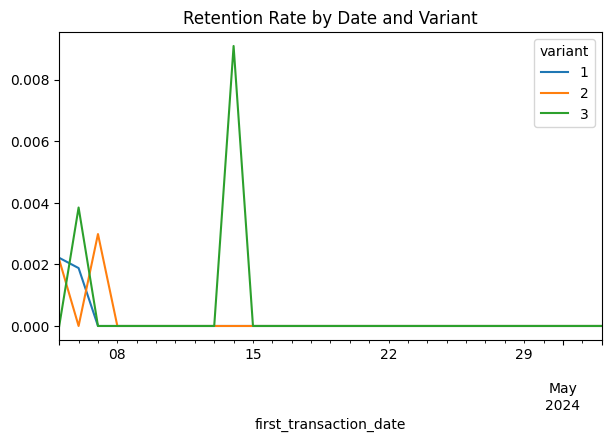

In [60]:
df_retention_test.pivot(
    index="first_transaction_date", columns="variant", values="retention_rate"
).plot(figsize=(7, 4), title="Retention Rate by Date and Variant")

In [61]:
df_retention_test_piv = df_retention_test.pivot(
    index="first_transaction_date", columns="variant", values="retention_rate"
).reset_index()

df_retention_test_piv[1] = round(df_retention_test_piv[1] * 100,2)
df_retention_test_piv[2] = round(df_retention_test_piv[2] * 100,2)
df_retention_test_piv[3] = round(df_retention_test_piv[3] * 100,2)

df_retention_test_piv

variant,first_transaction_date,1,2,3
0,2024-04-05,0.22,0.22,0.00
1,2024-04-06,0.19,0.00,0.38
2,2024-04-07,0.00,0.30,0.00
3,2024-04-08,0.00,0.00,0.00
4,2024-04-09,0.00,0.00,0.00
5,2024-04-10,0.00,0.00,0.00
6,2024-04-11,0.00,0.00,0.00
7,2024-04-12,0.00,0.00,0.00
8,2024-04-13,0.00,0.00,0.00
9,2024-04-14,0.00,0.00,0.91


## Answer to the Question-3

- To understand retention, I first calculated cumulative cohort-based return rates. This shows whether users came back at least once after their first transaction.

- Across all cohorts, variants follow a similar trend. Variant 3 performs slightly better in most cases, while Variant 2 consistently trails behind. However, the differences aren't that big on their own.

- But just coming back once doesn't say much about engagement. I wanted to understand whether users actually build a usage habit — so I calculated rolling retention, defined as being active at least 3 days in a 7-day window.

- That’s where the differences are clearer.
    - Variant 3 shows the most consistent user engagement. It peaks around day 6 and stays higher over time.
    - Variant 2, on the other hand, drops fast — users either churn early or never build recurring behavior.

- Rolling retention is a more behavioral metric. It tells us whether users are just trying the feature or actually integrating it into their habits.

- To validate this visually observed pattern, I tested whether the difference in retention rates on a specific day was statistically significant. I chose day 14 as the comparison point and ran a Kruskal-Wallis test, which is suitable given the non-normal distribution and small sample size.

    - For users who were active at least 3 days in the past 14 → p-value = 0.846
    - For users active at least 11 days → p-value = 0.996

- In both cases, I failed to reject the null hypothesis. Statistically speaking, there is no significant difference in 14th-day rolling retention across variants.

- So while Variant 3 appears better visually, this is not supported by statistically significant evidence at the end of the 14-day window — at least not in the current sample.

- This doesn’t mean Variant 3 isn’t better — it just means we can’t be confident yet, based on this test alone.

- If the goal of this feature is to drive habit formation or repeat interaction, Variant 3 remains the most promising, but more data is needed to back it with statistical confidence.

- And importantly, if revenue or purchase behavior isn’t clearly uplifted either, then rollout decisions should be made cautiously — or based on strategic goals beyond just short-term retention.



## Next Steps

- Stats
    - Check cohort balance (date, geo, device)
    - 95 % CIs + effect sizes
    - Multiple comparison tests like Holm


- Business

    - Easy to capture, concise slides: KPIs + ship / rerun / abort tree
    - Effects & Impacts alongside the statistical references

- Prod
    - Instead of CTEs in duckdb, go to real pipelines & probably airflow
    - Maybe a dashboard / tool to interact with the AB(C) test results

## Recommendations

- Hold rollout
    - Retention bump = noise (p > 0.05)
    - ARPU unchanged
    - Kill Variant 2, possible downside

- Rerun as powered A/B (Control vs V3) 

- Add Guard-rail metrics (auto-alert)
    - Revenue / user 
    - even more kpis with more data points

- Instrumentation
    - Real-time dashboard

- pip3 freeze

appnope==0.1.4
asttokens==3.0.0
attrs==25.3.0
beautifulsoup4==4.13.4
bleach==6.2.0
comm==0.2.2
contourpy==1.3.2
cycler==0.12.1
debugpy==1.8.14
decorator==5.2.1
defusedxml==0.7.1
duckdb==1.2.2
executing==2.2.0
fastjsonschema==2.21.1
fonttools==4.58.0
ipykernel==6.29.5
ipython==9.2.0
ipython_pygments_lexers==1.1.1
jedi==0.19.2
Jinja2==3.1.6
joblib==1.5.0
jsonschema==4.23.0
jsonschema-specifications==2025.4.1
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyterlab_pygments==0.3.0
kiwisolver==1.4.8
MarkupSafe==3.0.2
matplotlib==3.10.3
matplotlib-inline==0.1.7
mistune==3.1.3
nbclient==0.10.2
nbconvert==7.16.6
nbformat==5.10.4
nest-asyncio==1.6.0
numpy==2.2.6
packaging==25.0
pandas==2.2.3
pandas_flavor==0.7.0
pandasql==0.7.3
pandocfilters==1.5.1
parso==0.8.4
patsy==1.0.1
pexpect==4.9.0
pillow==11.2.1
pingouin==0.5.5
platformdirs==4.3.8
prompt_toolkit==3.0.51
psutil==7.0.0
ptyprocess==0.7.0
pure_eval==0.2.3
Pygments==2.19.1
pyparsing==3.2.3
python-dateutil==2.9.0.post0
pytz==2025.2
pyzmq==26.4.0
referencing==0.36.2
rpds-py==0.25.0
scikit-learn==1.6.1
scikit-posthocs==0.11.4
scipy==1.15.3
seaborn==0.13.2
six==1.17.0
soupsieve==2.7
SQLAlchemy==2.0.41
stack-data==0.6.3
statsmodels==0.14.4
tabulate==0.9.0
threadpoolctl==3.6.0
tinycss2==1.4.0
tornado==6.5
traitlets==5.14.3
typing_extensions==4.13.2
tzdata==2025.2
wcwidth==0.2.13
webencodings==0.5.1
xarray==2025.4.0